# 미국 중고차 가격 예측
- 조대선, 홍성현, 배준영, 유호원

## 가설
- 도시별 중고차 수요에 따른 가격차이가 있을것이다.
- 연비가 높을 수록 중고차 가격이 높을 것이다.
- 제조회사가 유명할 수록 중고차 가격이 높을 것이다.
- 연식이 오래된 중고차 일수록 가격이 낮을 것이다. 
- 같은 차종이 많이 있을 수록 가격이 낮을것이다.
- 상태가 좋을수록 평균가격에서 인센티브가 붙을것이다.
- Automatic 이 Manual 보다 비쌀것이다.
- 주행거리가 5만 키로일때 많이 팔 것이다. 
- 연식이 5년 이하일 때 많이 팔 것이다. 


## 데이터 출처
- Craigslist(크레이그리스트) https://craigslist.org/ : 중고 매물, 구인 구직, 주택, 자유 주제 토론등을 다루는 커뮤니티 웹사이트
- 2~3개월에 한번씩 주기적으로 수집된 미국내 중고차 매물 약 51만 건(업데이트 : 2020년 1월)
- 데이터 출처 : https://www.kaggle.com/austinreese/craigslist-carstrucks-data (캐글)
- Craigslist Filter 웹 애플리케이션(https://craigslist-filter.herokuapp.com/)
- 웹 애플리케이션 github : https://github.com/AustinReese/craigslistFilter (github)


<img src="./img/img2.png" width="1200">

In [101]:
import re
import missingno as msno
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from scipy import stats
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score


pd.set_option('display.max_columns', 500)
pd.options.display.float_format = '{:.2f}'.format

In [188]:
%%html
<style>
table {float:left}
table td, table th {
        border-style: solid;
        font-size: 14px;
}
li {
    font-size: 15px;
    margin:5px;
}
</style>


## 컬럼 정보

|컬럼명|내용|설명|
|:------|:---|:---|
|<span style= 'background:yellow'> **price** </span> | **entry price** |  **중고차 가격**|
|<span style= 'background:pink'>**year**</span> | **entry year** | **중고차 연식**|
|<span style= 'background:pink'>**manufacturer**</span> |  **manufacturer of vehicle**| **제조사**|
|<span style= 'background:pink'>**cylinders**</span> |  **number of cylinder** | **엔진 기통수** |
|<span style= 'background:pink'>**fuel**</span> |  **fuel type** | **연료타입** |
|<span style= 'background:pink'>**odometer**</span> |  **miles traveled by vehicle**| **총주행거리**|
|<span style= 'background:pink'>**title_status**</span> |  **title status of vehicle** |**차량 상태**|
|<span style= 'background:pink'>**transmission**</span> |  **transmission of vehicle**| **미션**|
|<span style= 'background:pink'>**vin**</span> |  **vehicle identification numbe**| **차대번호**|
|<span style= 'background:pink'>**drive**</span> |  **type of drive** |**구동방식**|
|<span style= 'background:pink'>**size**</span> |  **size of vehicle** | **차량크기**|
|<span style= 'background:pink'>**type**</span> |  **generic type of vehicle**| **차량 타입**|
|<span style= 'background:pink'>**paint_color**</span> |  **color of vehicle**| **차량 색상**|
|<span style= 'background:pink'>**state**</span> |  **state of listing**| **주 명**|
|condition |  condition of vehicle|차량 상태||
|lat|  latitude of listing| 위도|
|long |  longitude of listing| 경도|
|url |  listing  | 중고차 등록 URL |
|region |  craigslist region | 중고차 거래 지역|
|region_url |  region URL | 중고차 지역 정보 URL|
|image_url |  image URL | 중고차 사진 URL|
|description |  listed description of vehicle|  중고차 상태 설명|
|county |  useless column left in by mistake | 행정 구역 단위 (데이터 없음)|
|model |  model of vehicle| 차량 모델명|

### **예측에 도움이 되지 않는 데이터**
  - 텍스트 데이터
    - 'url','region_url','image_url','description','county'
  - 위치정보
    - 'lat','long'
  - 'model' : 다른 feature들의 대표성을 띄는 데이터 (다중 공선성 발생)
  - 'size' : 결측치 50% 이상
  - 'condition' : 결측치 45% 이상
  - 'county' : 크롤링 과정에서 누락된 데이터

# 데이터 탐색

## 전처리

In [4]:
raw_data = pd.read_csv("vehicles.csv")

In [5]:
start_df = raw_data[['id','price','year','odometer','drive','fuel','manufacturer','state','title_status','transmission','type','paint_color','cylinders','vin']]

In [6]:
start_df.shape

(509577, 14)

### 결측치 확인

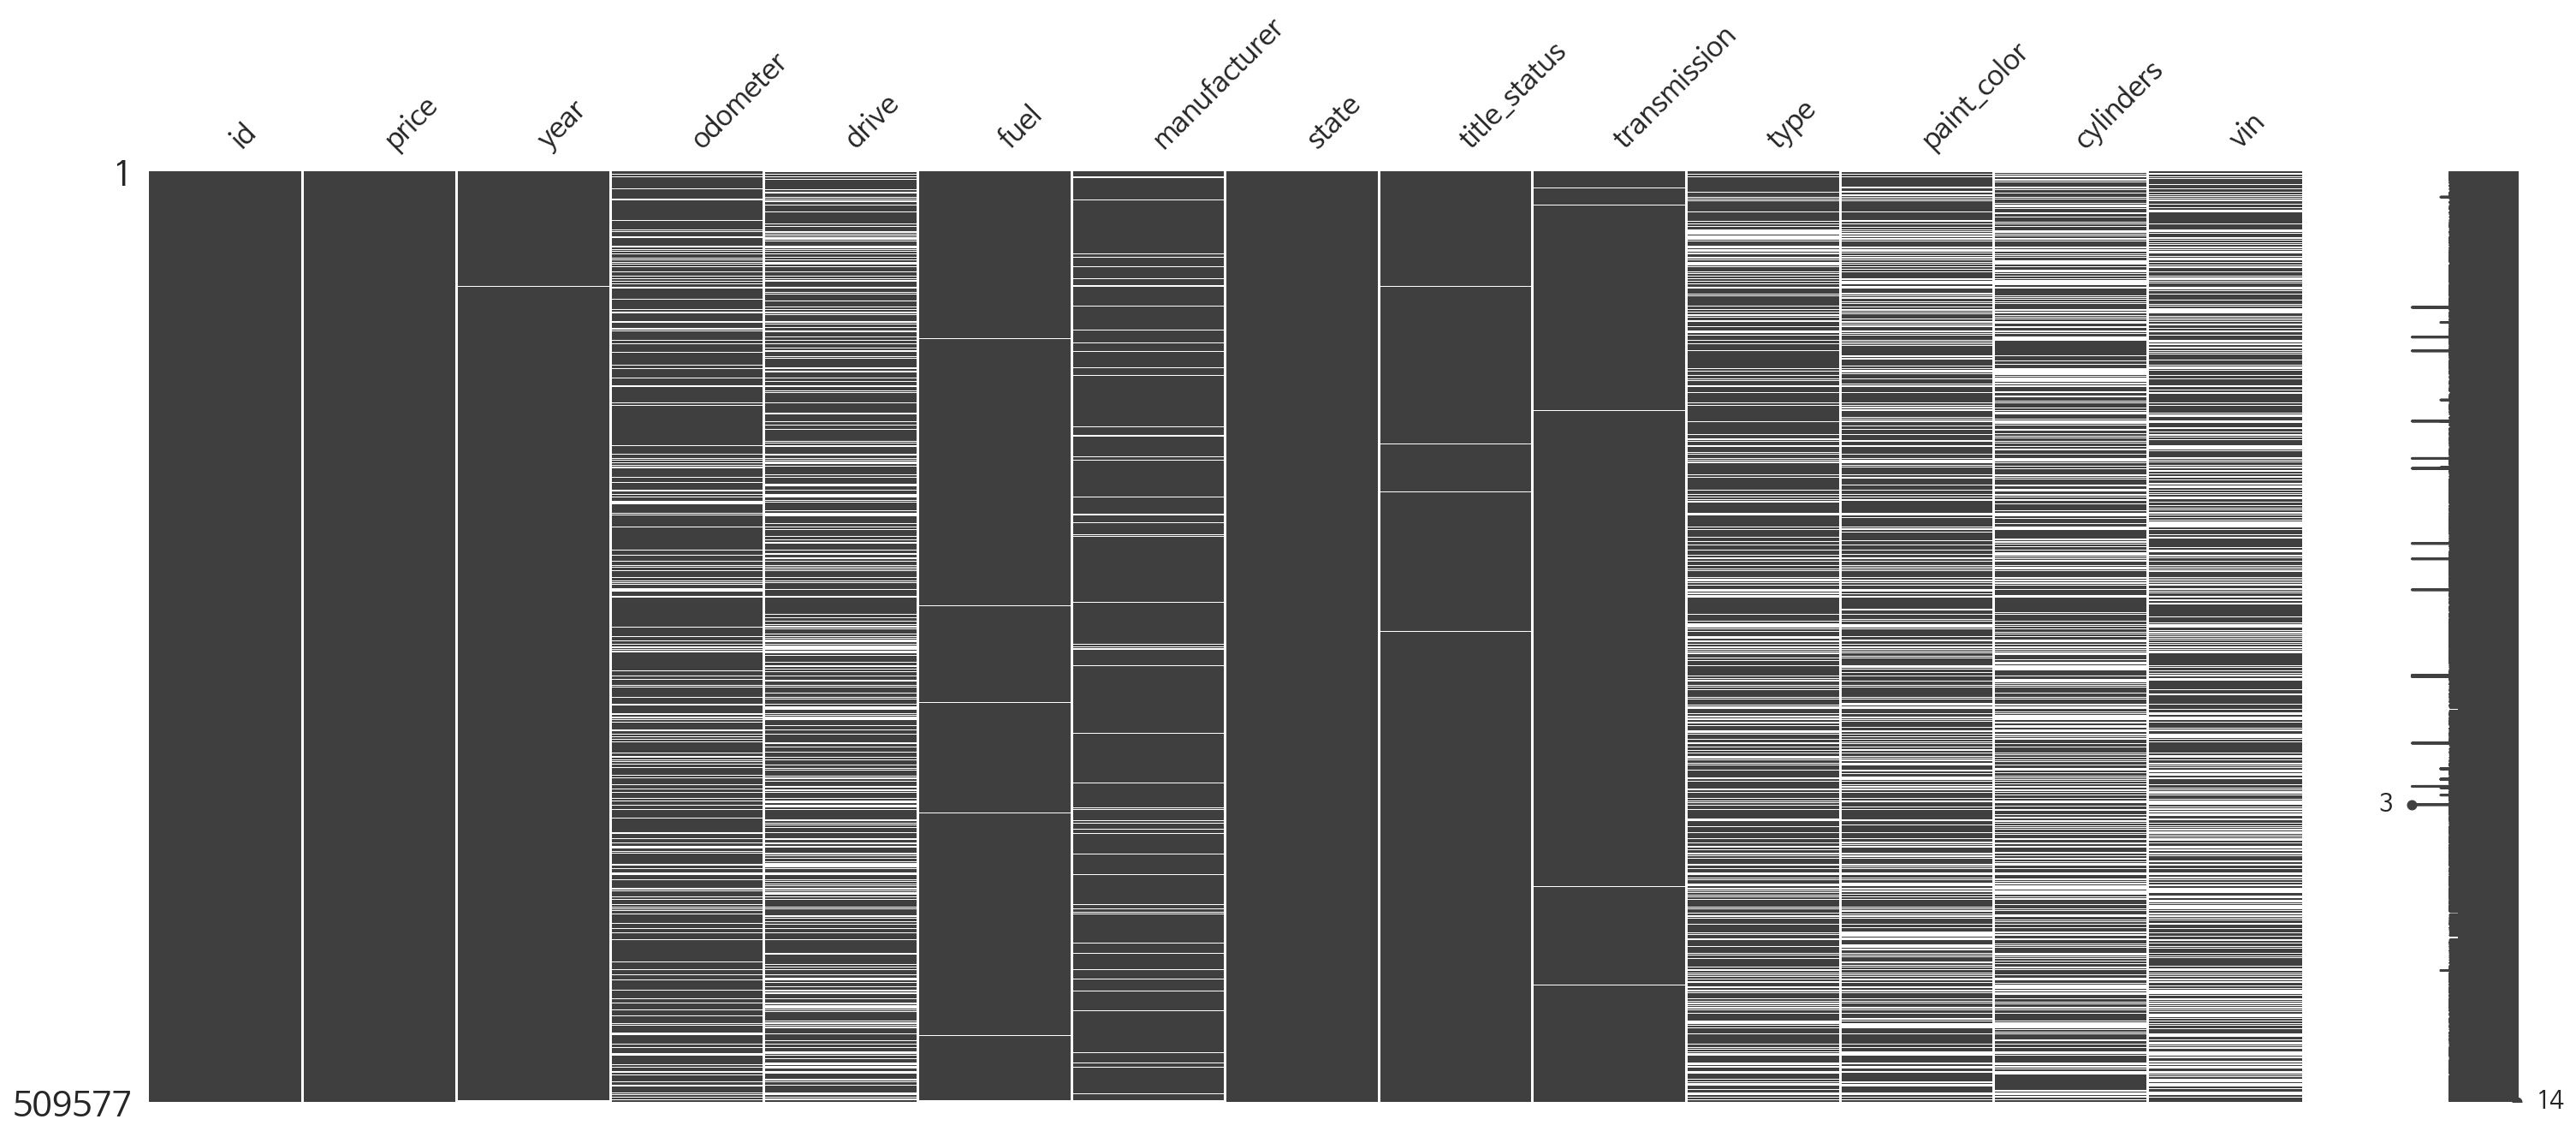

In [7]:
msno.matrix(start_df)

#### 결측치 수치화

In [8]:
def columns_na_percentage(columns):
    for column in columns:
        percentage = round(100 -(len(raw_data['{}'.format(column)].dropna()) / len(raw_data)) * 100,2)
        if percentage :
            print("{} : ".format(column), percentage,"%",end='\n')

In [9]:
columns_na_percentage(start_df.columns)

year :  0.3 %
odometer :  18.12 %
drive :  28.29 %
fuel :  0.78 %
manufacturer :  4.47 %
title_status :  0.6 %
transmission :  0.73 %
type :  27.77 %
paint_color :  32.32 %
cylinders :  39.19 %
vin :  40.71 %


#### 결측치 제거 

In [10]:
start_df = start_df.dropna(axis=0)
start_df.shape

(120609, 14)

## 차대 번호(vin)를 활용한 데이터 필터링

- **Step1**
    - 중복된 'vin'을 가지고 있는 데이터 삭제

In [11]:
df = start_df.loc[start_df['vin'].drop_duplicates(keep='last').index]
df.shape

(77678, 14)

- **Step2**
    - 'vinaudit.com'이 제공하는 api를 이용
    - ####  'vinaudit.com'의 데이터 베이스
     <img src="./img/img1.png" width="700" style="float:left">

- **데이터 출처**
    - 자동차 이력 제공시스템 : (NMVTIS/National Motor Vehicle Title Information System)
    - 미국 도로교통 안전국 : (NHTSA / National Highway Traffic Safety Administration)
    - 미국 교통부 연방차량안전국 : (Federal Motor Carrier Safety Administration, FMCSA) 
    - 그외 미국 정부 기관과 관련된 업체 및 파트너사

### 데이터 크롤링

In [12]:
last1= pd.read_csv('./crawlinf_raw_data/vin_crawling_data.csv')
last2 = pd.read_csv('./crawlinf_raw_data/20000-28500vin_crawling.csv')
last3 = pd.read_csv('./crawlinf_raw_data/vin_df.csv')
last4 = pd.read_csv('./crawlinf_raw_data/last4.csv')
vin_crawling_data = pd.concat([last1,last2,last3,last4])
vin_crawling_data_drop_dupli = vin_crawling_data.drop_duplicates('vin',keep='first')
vin_crawling_data = vin_crawling_data_drop_dupli[vin_crawling_data_drop_dupli.columns.difference(['Unnamed: 0','Unnamed: 0.1','og_vin','id'])]
vin_crawling_data.shape

(77578, 13)

## 크롤링 데이터 분석

|컬럼명|설명|
|:------|:---|
| **above** | 최대 가격|
|**average** | 평균 가격|
|**below** | 최소 가격 |
|**certainty** | 정확도 |
|**count**|  거래 횟수|
|**error** |  에러 메세지 |
|**mileage**|  주행 거리 |
|**period**|  거래 시기|
|**stdev**|  표준 편차|
|**success**|  성공 여부|
|**vehicle**|  차량 정보 (연식, 제조사, 모델명)|

<img src="./img/img3.png" width="600">

- **데이터 사용처**
    - Carmax,carfax등 미국 중고차 매매 업체
    - Vincheck등 중고차 매물 검색 업체

### 크롤링 데이터를 활용한 데이터 필터링

In [13]:
# 대문자 변경
vin_crawling_data['vin'] = vin_crawling_data['vin'].str.upper()

# 중복제거
vin_crawling_data_drop_dupli = vin_crawling_data.drop_duplicates('vin',keep='first')

# 대문자 변경
df['vin'] = df['vin'].str.upper()

# merge
final = pd.merge(df,vin_crawling_data_drop_dupli,on='vin')

# 중복 제거
final_drop_dupli = final.drop_duplicates('vin',keep='first')

df = final_drop_dupli[final_drop_dupli.columns.difference(['id_y','Unnamed: 0','Unnamed: 0.1','og_vin'])]
df.shape

(77569, 26)

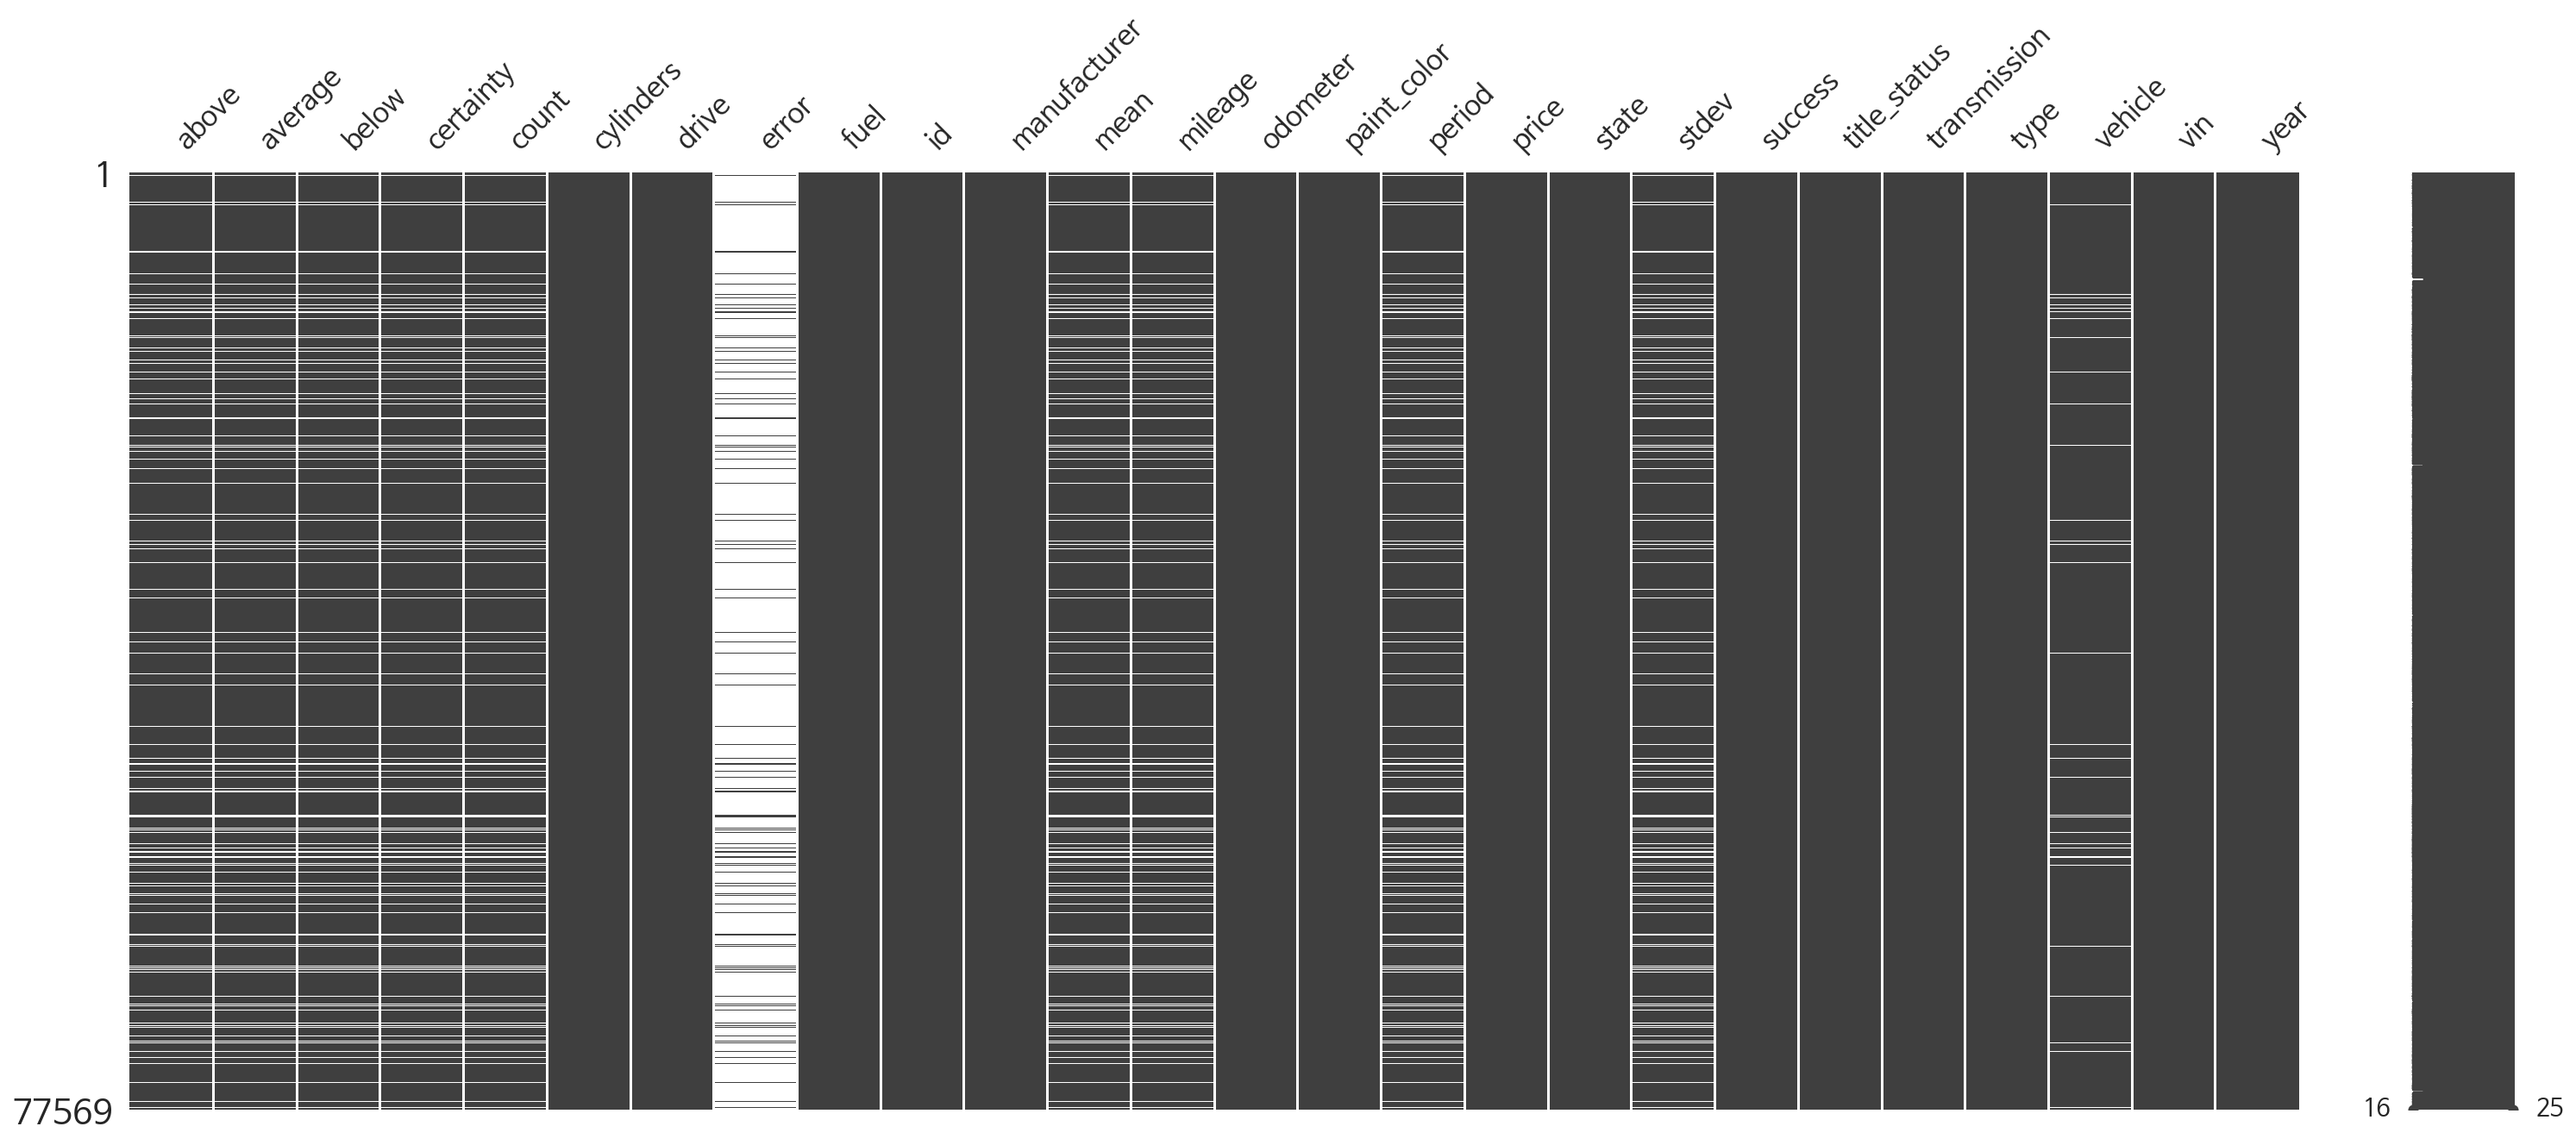

In [14]:
msno.matrix(df)

### error 컬럼 
- 'no_data' : request시에 던져준 'odometer'가 잘못되어 가격 및 정보를 가져올수 없는 경우
- 'invalid_vin' : request시에 던져준 'vin'이 17자리가 아닌 경우
  - 1980년도 이전에 생산된 차량의 정보는 데이터베이스화 되어있지 않음
  - 판매자가 잘못된 vin값을 입력한 경우

In [16]:
df['error'].value_counts()

no_data        4263
invalid_vin    3038
Name: error, dtype: int64

- 'error'값을 가지고 있는 row들을 제거

In [17]:
test=df[df.columns.difference(['error'])]

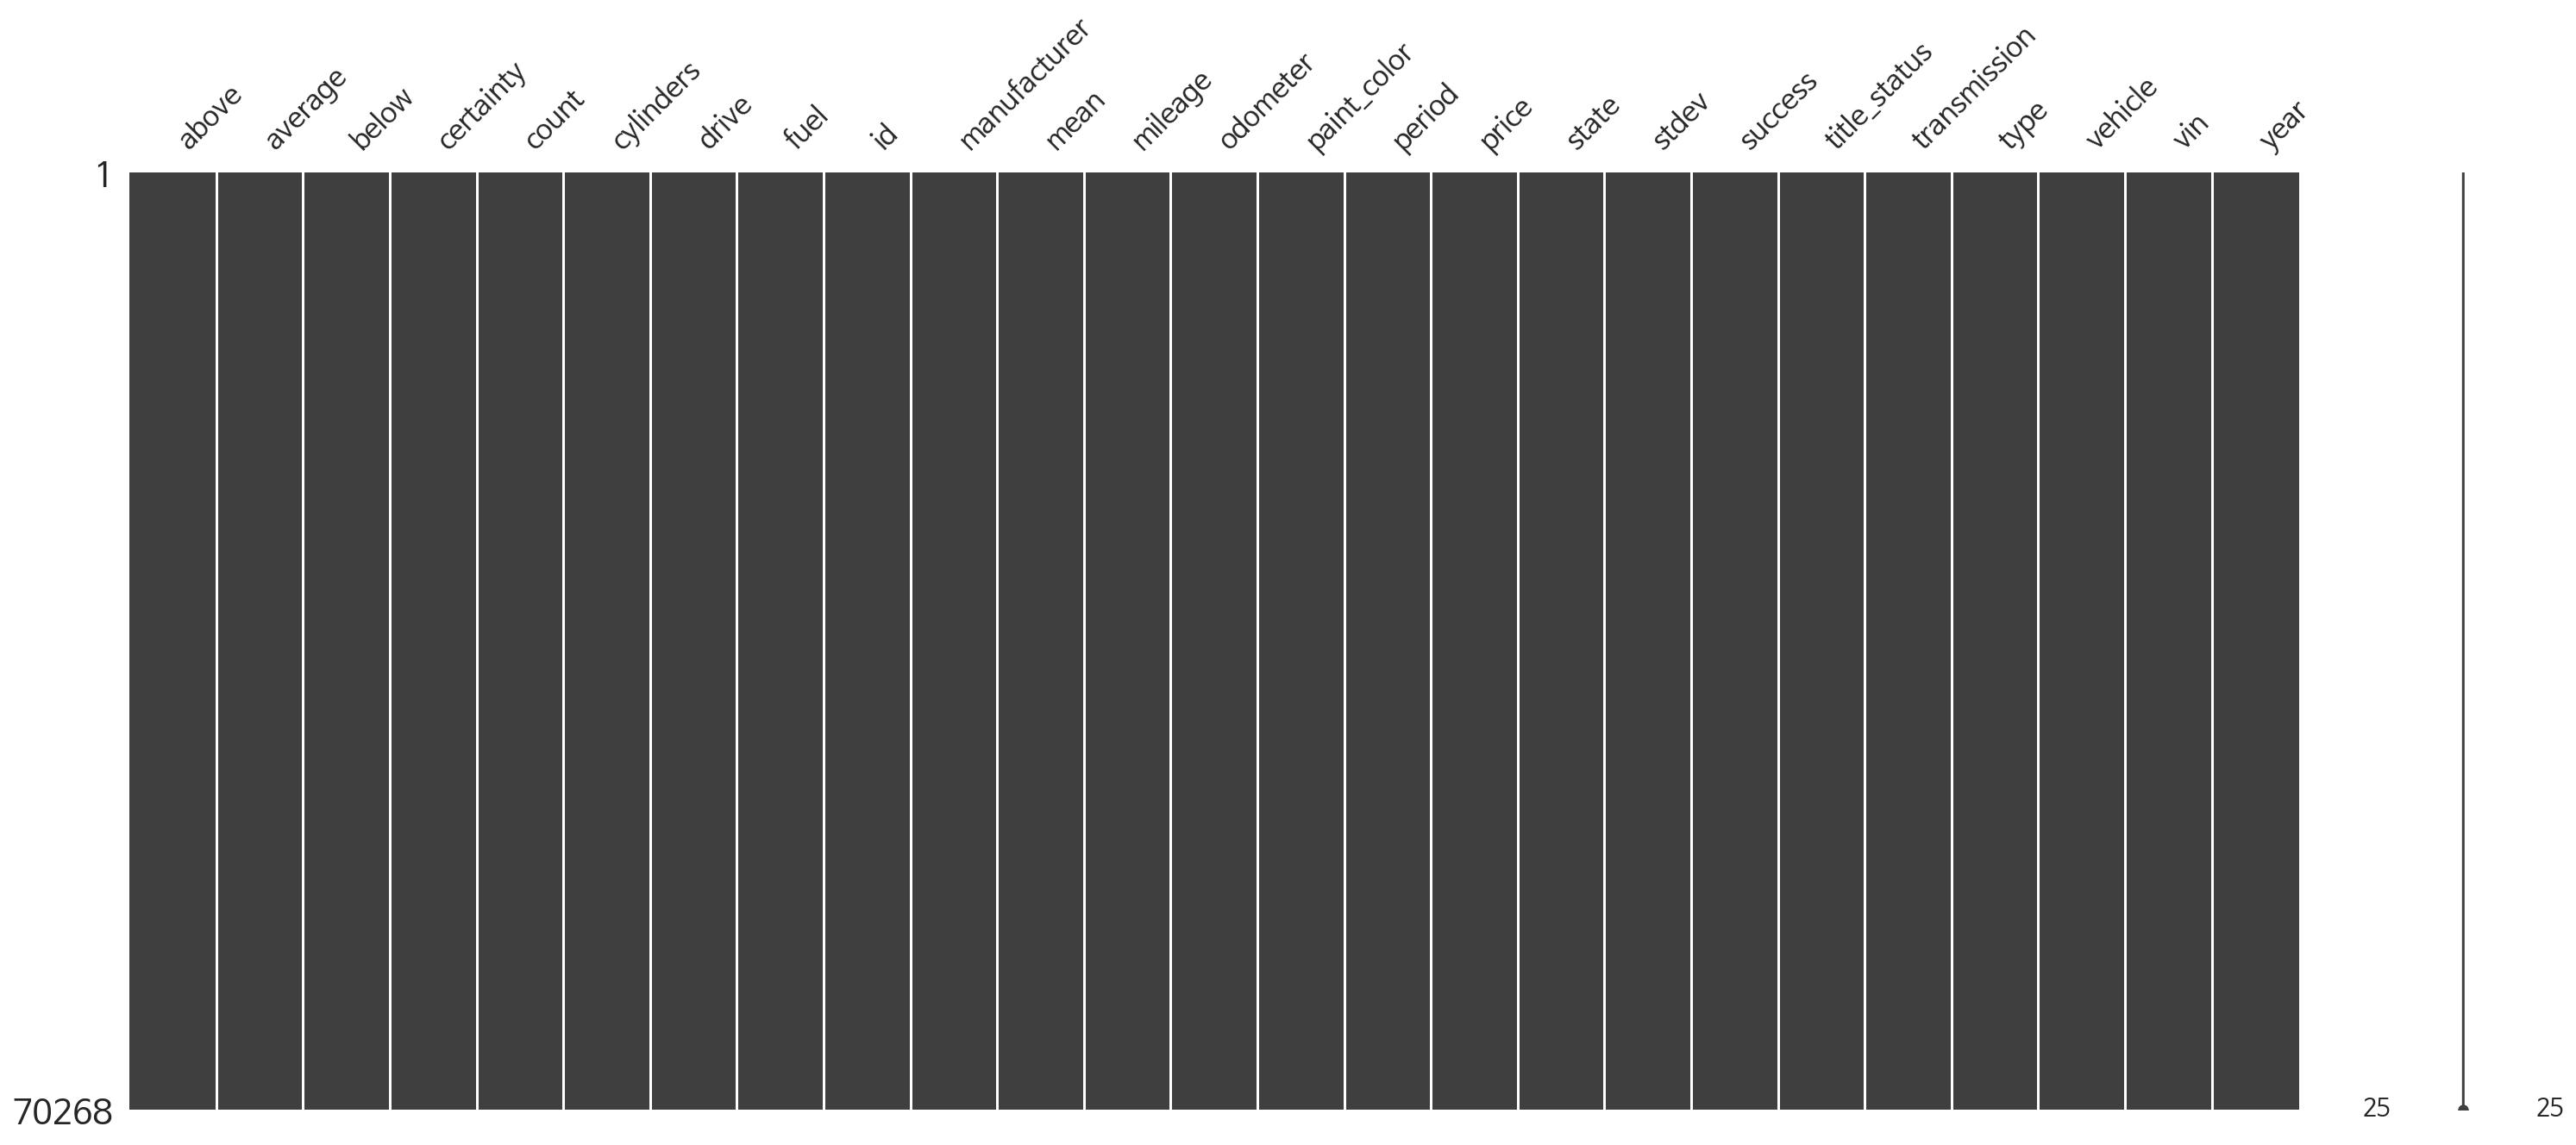

In [18]:
test = test.dropna(axis=0)
msno.matrix(test)

## 가격 필터링

- 평균가격과 표준편차를 이용해 'price'의 아웃라이어를 필터링

In [19]:
test[['above', 'average', 'below','stdev']].head(2)

,above,average,below,stdev
0,20878.90,18399.90,15920.90,2479.00
1,8113.75,6710.75,5307.75,1403.00


### 평균값과 표준편차를 이용해 sigma 정하기

In [50]:
def get_sigma_data_by_price(num):
    global test2
    # price가 0인것들 제거
    test2 = test[(test['price'] >= (test['average'] - (test['stdev']*num))) & (test['price'] <= (test['average'] + (test['stdev']*num)))]
    print("{} sigma data : ".format(num),test2.shape)

In [51]:
get_sigma_data_by_price(1)
test2.shape

1 sigma data :  (42596, 25)


(42596, 25)

In [52]:
# year를 int로 형변환
test2['year'] = test2['year'].astype('int')

### 주행거리 필터링
- odometer와 mileage가 다른 데이터 : 판매자가 과도하게 높은 odometer를 입력한 경우

In [53]:
print("주행거리 아웃라이어 : ",len(test2[test2['mileage'] != test2['odometer']]))
test2[test2['mileage'] != test2['odometer']].head(2)

주행거리 아웃라이어 :  13


,above,average,below,certainty,count,cylinders,drive,fuel,id,manufacturer,mean,mileage,odometer,paint_color,period,price,state,stdev,success,title_status,transmission,type,vehicle,vin,year
8407,5276.60,4335.60,3394.60,65.00,4.00,8 cylinders,4wd,gas,7034479993,dodge,4335.60,180265.00,4000085.00,custom,"['2019-10-05', '2020-01-15']",3995,al,941.00,True,clean,automatic,SUV,2004 Dodge Durango SLT,1D4HB48N44F169643,2004
10373,18119.72,16055.72,13991.72,99.00,180.00,6 cylinders,rwd,gas,7049079431,chevrolet,16055.72,60482.00,1000296.00,black,"['2019-10-01', '2020-03-26']",15000,az,2064.00,True,clean,automatic,coupe,2014 Chevrolet Camaro LT,2G1FB1E37E9298002,2014


In [54]:
# 주행거리 아웃라이어 제거
test2 = test2[test2['mileage'] == test2['odometer']]

### 박스플롯, 스캐터 플롯

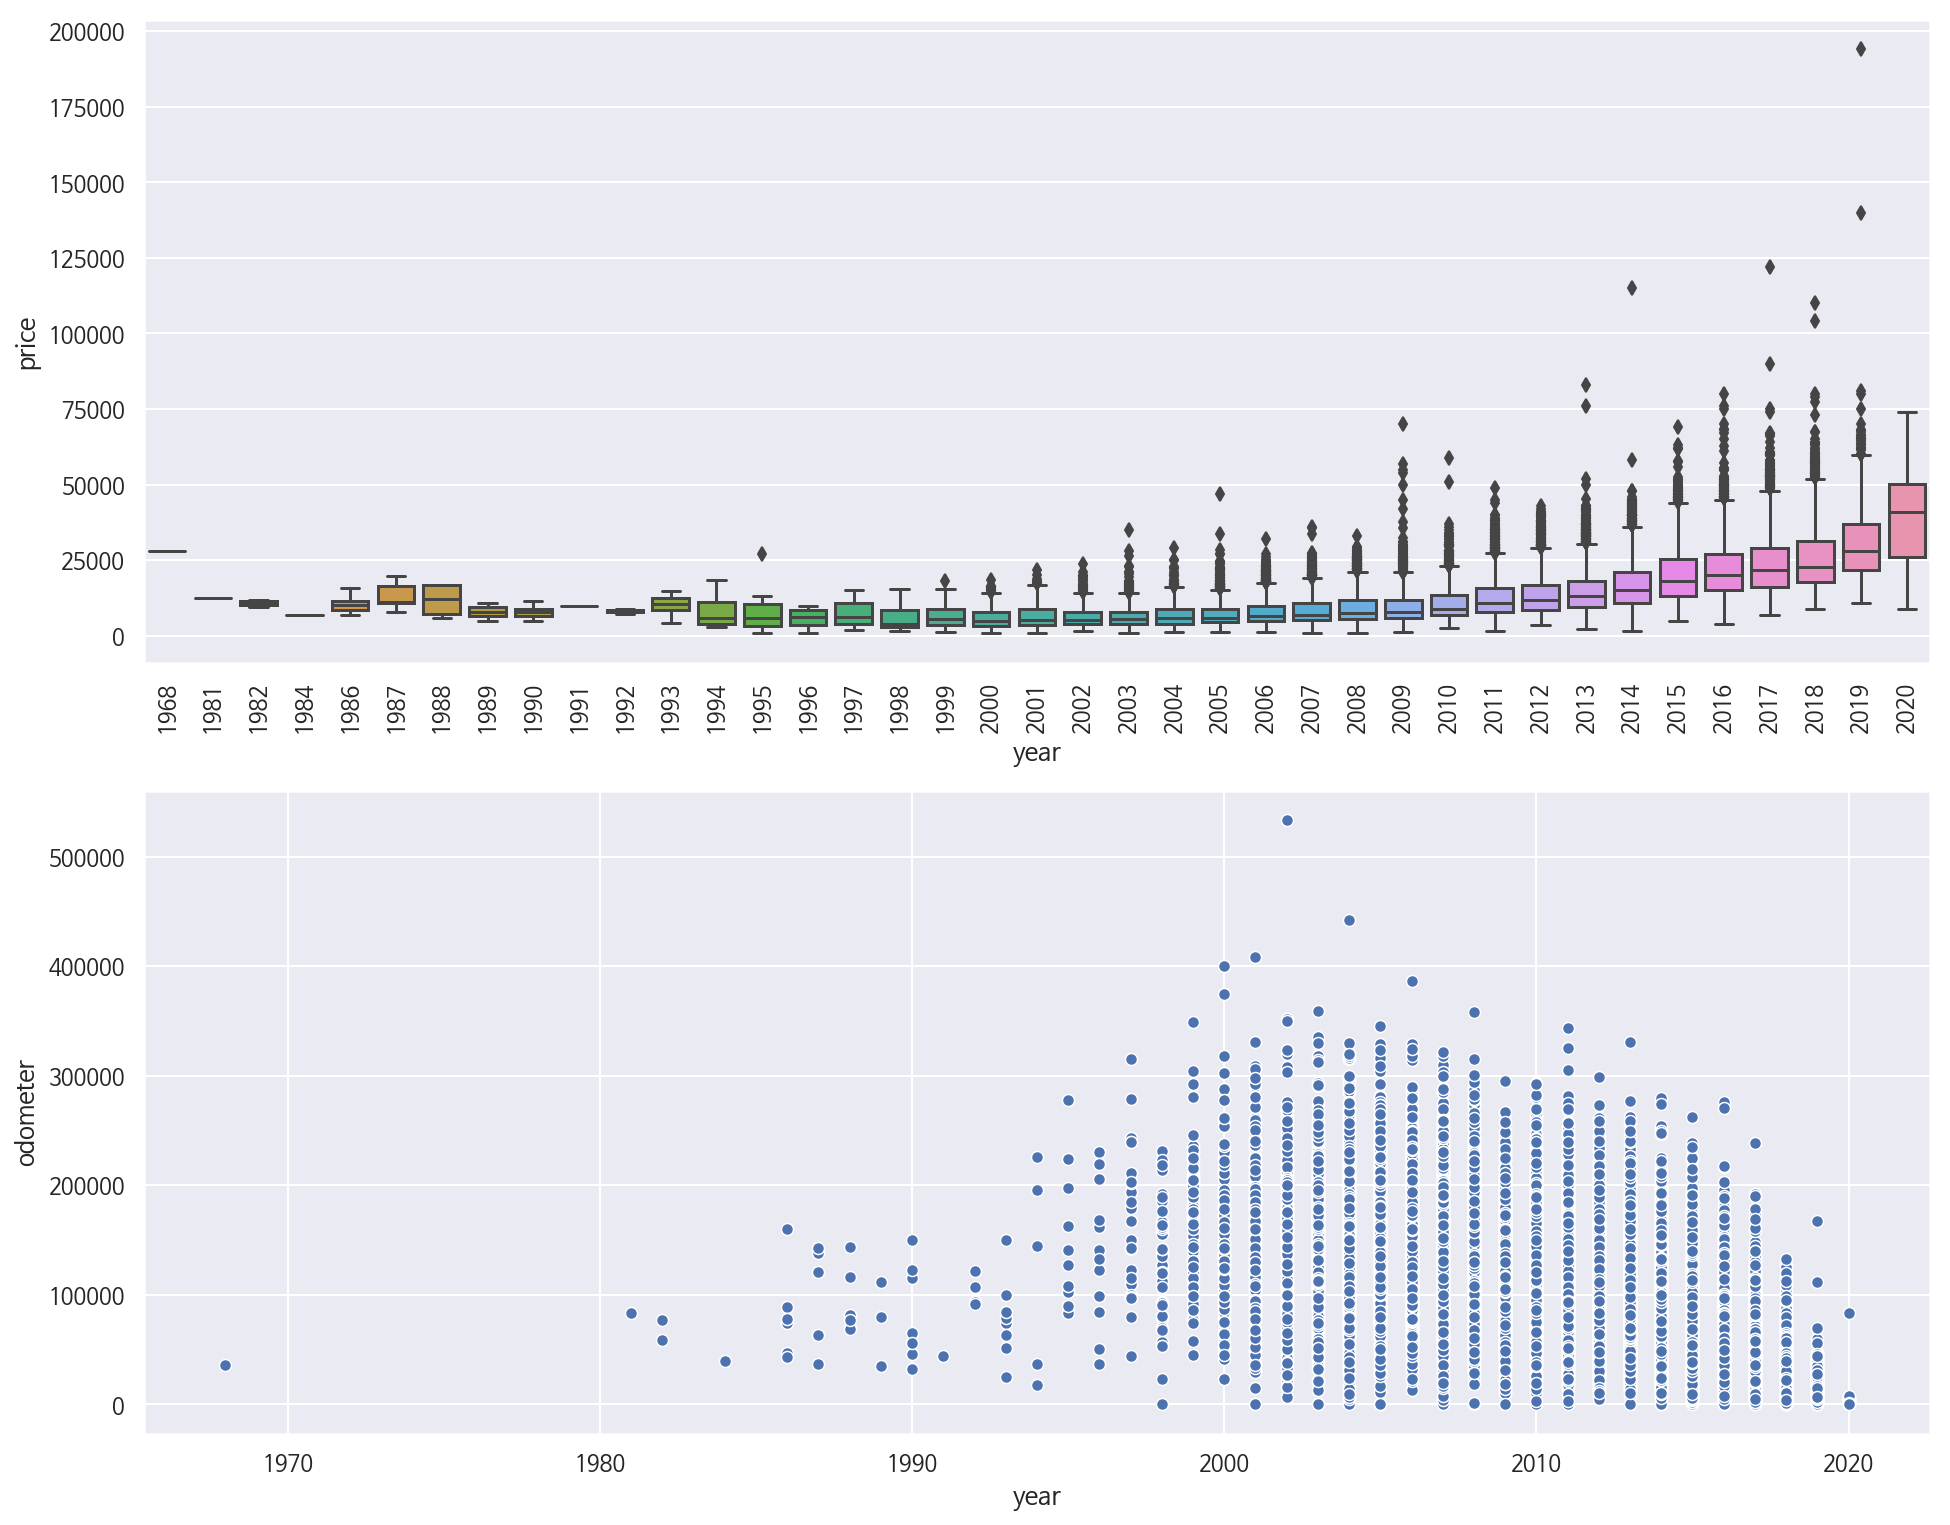

In [55]:
plt.figure(figsize=(16,13))
plt.subplot(211)
sns.boxplot(x="year", y="price", data = test2)
plt.xticks(rotation=90)
plt.subplot(212)
sns.scatterplot(test2['year'],test2['odometer'])
# plt.subplot(313)
# sns.scatterplot(test2['year'],test2['price'])

plt.show()

## 플롯 그린후 눈으로 본 데이터

In [56]:
# year 수정해 줘야 하는 데이터
test2[test2['year'] < 1980]

,above,average,below,certainty,count,cylinders,drive,fuel,id,manufacturer,mean,mileage,odometer,paint_color,period,price,state,stdev,success,title_status,transmission,type,vehicle,vin,year
49431,31752.09,28691.09,25630.09,99.00,240.00,8 cylinders,rwd,gas,7035287698,pontiac,28691.09,36211.00,36211.00,blue,"['2019-12-14', '2020-03-26']",27988,mt,3061.00,True,clean,automatic,other,2019 Toyota Sienna,5TDYZ3DC0KS008940,1968


In [57]:
test2['year'] = test2['year'].apply(lambda x : 2019 if x < 1980 else x)

In [58]:
test2[test2['odometer'] > 500000]

,above,average,below,certainty,count,cylinders,drive,fuel,id,manufacturer,mean,mileage,odometer,paint_color,period,price,state,stdev,success,title_status,transmission,type,vehicle,vin,year
28776,9045.70,6984.70,4923.70,65.00,4.00,8 cylinders,4wd,gas,7044009302,toyota,6984.70,533000.00,533000.00,grey,"['2019-10-03', '2020-02-20']",6500,ga,2061.00,True,clean,automatic,SUV,2002 Toyota Land Cruiser Base,JTEHT05J722017912,2002


In [197]:
# 약 18년간 운행한 자동차의 일 평균 주행거리 계산
print("평균 주행거리 : ",round(533000.00 / (365* 18),2),"마일/day")

평균 주행거리 :  81.13 마일/day


In [59]:
test2[test2['price'] > 75000].sort_values(by=['price'],ascending=False).head()

,above,average,below,certainty,count,cylinders,drive,fuel,id,manufacturer,mean,mileage,odometer,paint_color,period,price,state,stdev,success,title_status,transmission,type,vehicle,vin,year
60128,202032.56,182660.56,163288.56,90.00,16.00,8 cylinders,4wd,gas,7045671330,mercedes-benz,182660.56,7584.00,7584.00,white,"['2019-10-03', '2020-03-26']",193982,oh,19372.00,True,clean,automatic,SUV,2019 Mercedes-Benz,WDCYC7HJ3KX301396,2019
29627,149400.58,132238.58,115076.58,70.30,5.00,3 cylinders,4wd,hybrid,7048009986,bmw,132238.58,649.00,649.00,grey,"['2019-10-05', '2020-03-14']",139995,hi,17162.00,True,clean,automatic,convertible,2019 BMW,WBY2Z6C52KVB82784,2019
20351,130595.38,124912.38,119229.38,79.60,8.00,10 cylinders,4wd,gas,7049707044,audi,124912.38,25624.00,25624.00,red,"['2019-10-06', '2020-03-19']",121995,co,5683.00,True,clean,automatic,coupe,2017 Audi R8 (V10 quattro),WUAEAAFX4H7901309,2017
10976,125445.67,119893.67,114341.67,74.20,6.00,8 cylinders,rwd,gas,7043599850,ferrari,119893.67,12986.00,12986.00,black,"['2019-10-03', '2020-03-22']",114950,az,5552.00,True,clean,automatic,convertible,2014 Ferrari California Base,ZFF65TJAXE0200770,2014
73531,117293.94,105051.94,92809.94,90.70,17.00,8 cylinders,rwd,gas,7047378977,mercedes-benz,105051.94,5560.00,5560.00,black,"['2019-10-01', '2020-03-26']",109995,tx,12242.00,True,clean,automatic,convertible,2018 Mercedes-Benz AMG GT Base,WDDYK7HA6JA014263,2018


### 추가 필터링
- price, odometer 값이 0인 경우 제거

In [60]:
print("판매자가 주행거리를 0으로 올려둔 경우 : ",len(test2[test2['odometer'] == 0]),"건")
test2[test2['odometer'] == 0].head(2)
test2= test2[test2['odometer'] != 0]

판매자가 주행거리를 0으로 올려둔 경우 :  17 건


In [61]:
# vinaudit에서 가격을 예측 했으나, 판매자가 가격을 매기지 않고 0이라고 올려둔 경우
print("판매자가 가격을 매기지 않고 0이라고 올려둔 경우 : ",len(test2[test2['price'] == 0]),"건")
test2[test2['price'] == 0].head(2)
test2= test2[test2['price'] != 0]

판매자가 가격을 매기지 않고 0이라고 올려둔 경우 :  0 건


## 변수탐색

### 종속변수 - 가격(price)

In [62]:
test2.price.sort_values(ascending=False)[:20]

60128    193982
29627    139995
20351    121995
10976    114950
73531    109995
14452    103999
16013     89800
61873     82991
29598     80905
77616     79997
56725     79995
19853     79970
65025     78900
14172     77500
23913     75999
30753     75977
36235     75000
20027     74999
56689     74900
71749     73915
Name: price, dtype: int64

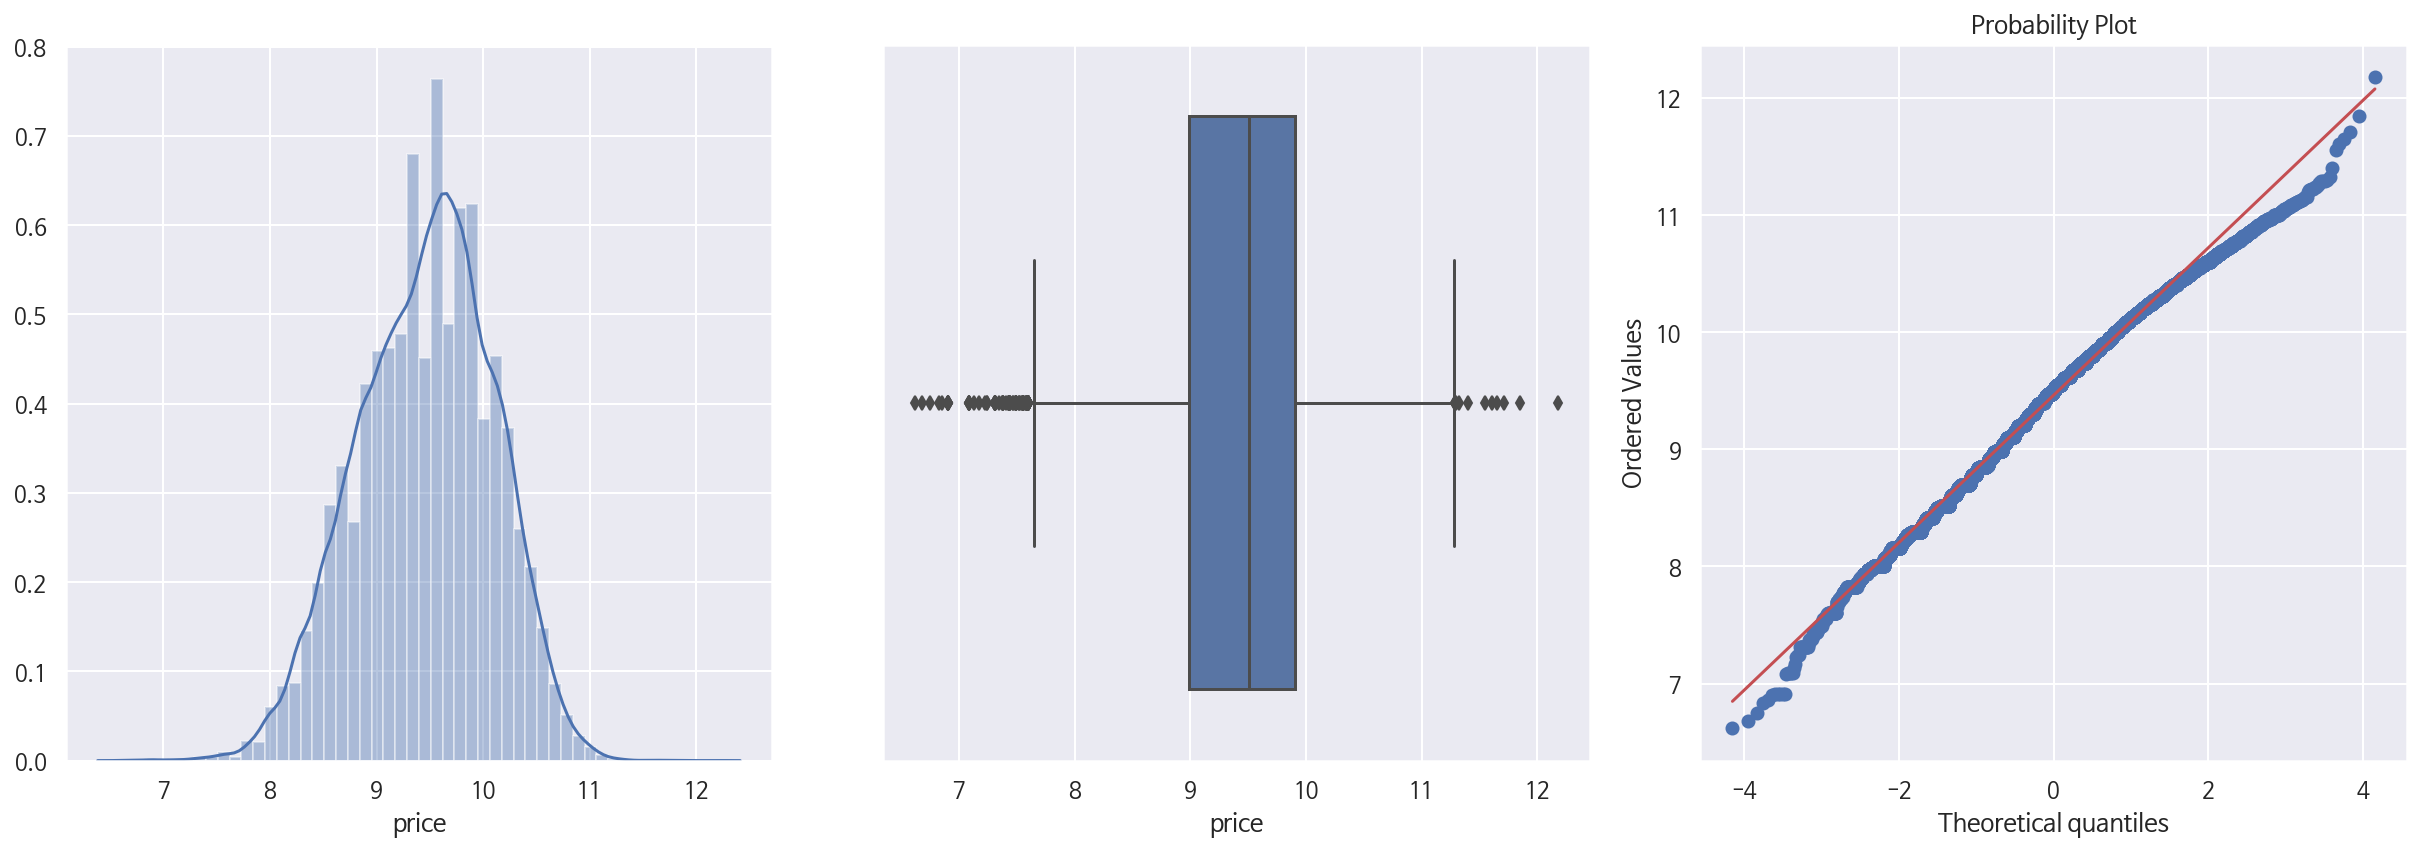

In [64]:
plt.figure(figsize=(17,6))

plt.subplot(131)
sns.distplot(np.log(test2['price']))

plt.subplot(132)
sns.boxplot(np.log(test2['price']))

plt.subplot(133)
stats.probplot(np.log(test2['price']),plot=plt)
plt.tight_layout()
plt.show()

### 독립변수

### 연식

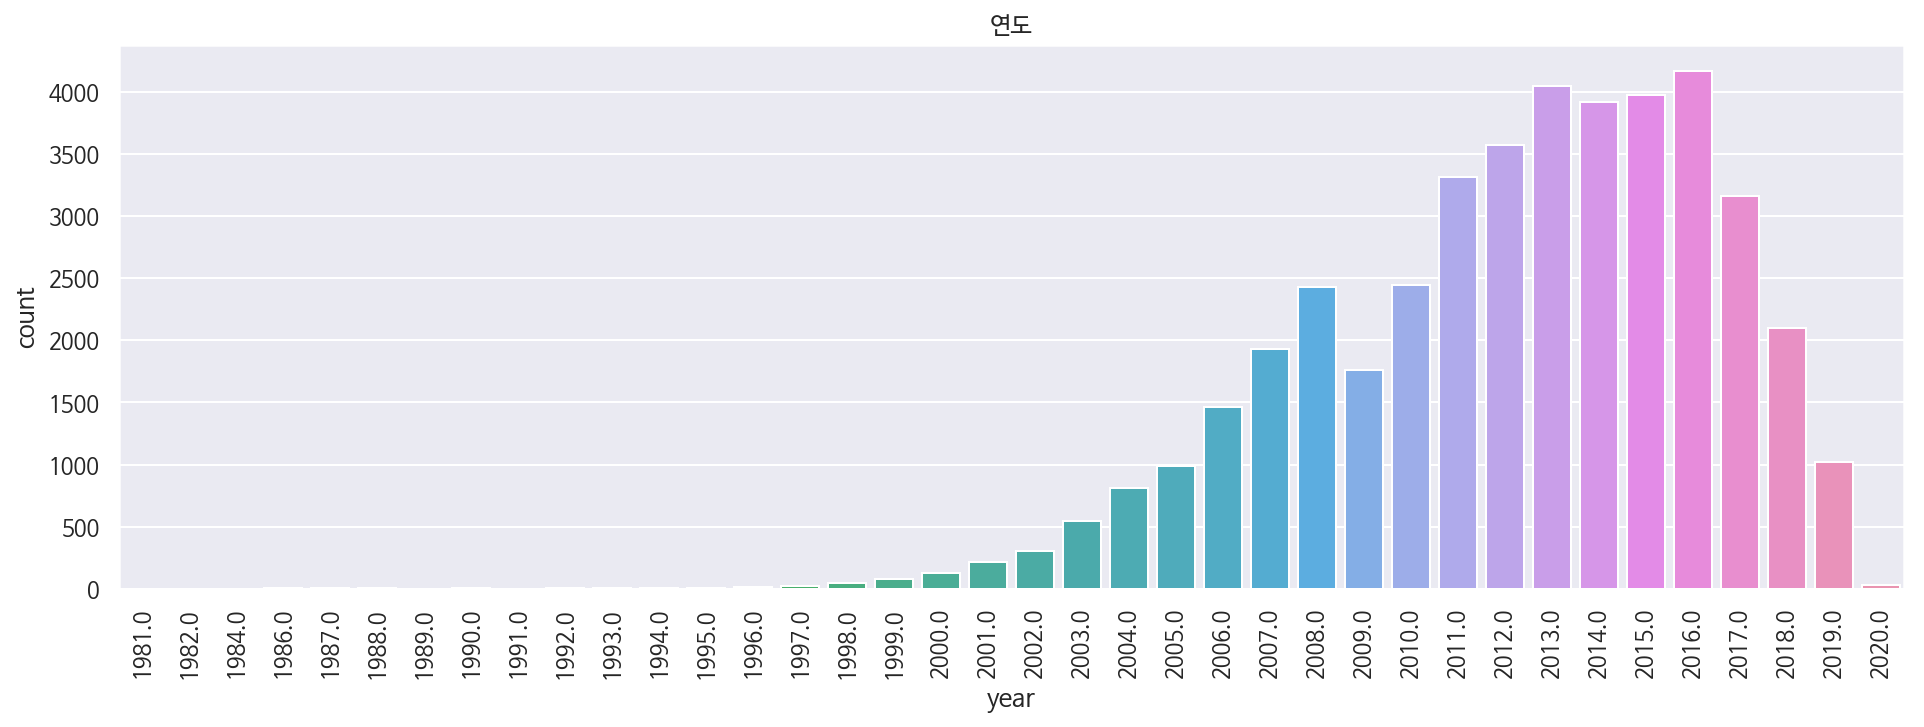

In [198]:
plt.figure(figsize=(16,5))
sns.countplot(
    test2['year']
)
plt.title("연도")
plt.xticks(rotation=90)
plt.show()

### 주행거리

(0, 250000)

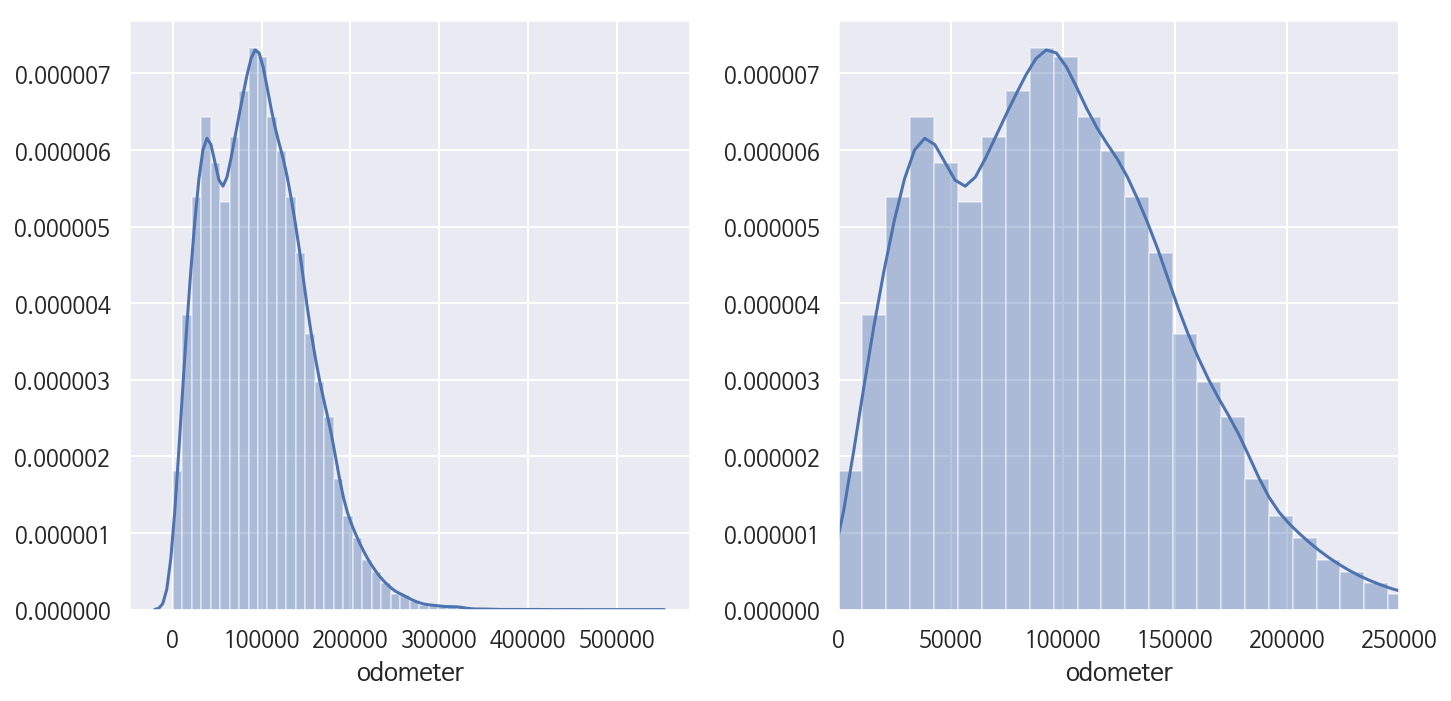

In [89]:
plt.figure(figsize=(10,5))
plt.subplot(121)
sns.distplot(test2['odometer'])
plt.subplot(122)
sns.distplot(test2['odometer'])
plt.tight_layout()
plt.xlim(0,250000)

### 독립변수 확인

In [294]:
for column in df.columns.difference(['id','vin','price','year']):
    print(df[column].describe(),"\n\n",df[column].unique(),end='\n\n----------------------\n\n')

count           77678
unique              8
top       6 cylinders
freq            28354
Name: cylinders, dtype: object 

 ['4 cylinders' '8 cylinders' '6 cylinders' '5 cylinders' '10 cylinders'
 '3 cylinders' 'other' '12 cylinders']

----------------------

count     77678
unique        3
top         4wd
freq      33486
Name: drive, dtype: object 

 ['4wd' 'fwd' 'rwd']

----------------------

count     77678
unique        5
top         gas
freq      71045
Name: fuel, dtype: object 

 ['gas' 'diesel' 'other' 'hybrid' 'electric']

----------------------

count     77678
unique       42
top        ford
freq      13646
Name: manufacturer, dtype: object 

 ['volkswagen' 'honda' 'subaru' 'ram' 'mercedes-benz' 'ford' 'chevrolet'
 'dodge' 'kia' 'nissan' 'toyota' 'saturn' 'jeep' 'chrysler' 'hyundai'
 'pontiac' 'mitsubishi' 'gmc' 'lexus' 'audi' 'mazda' 'fiat' 'lincoln'
 'acura' 'mini' 'volvo' 'rover' 'bmw' 'cadillac' 'infiniti' 'buick'
 'alfa-romeo' 'jaguar' 'mercury' 'tesla' 'ferrari' 'datsun'

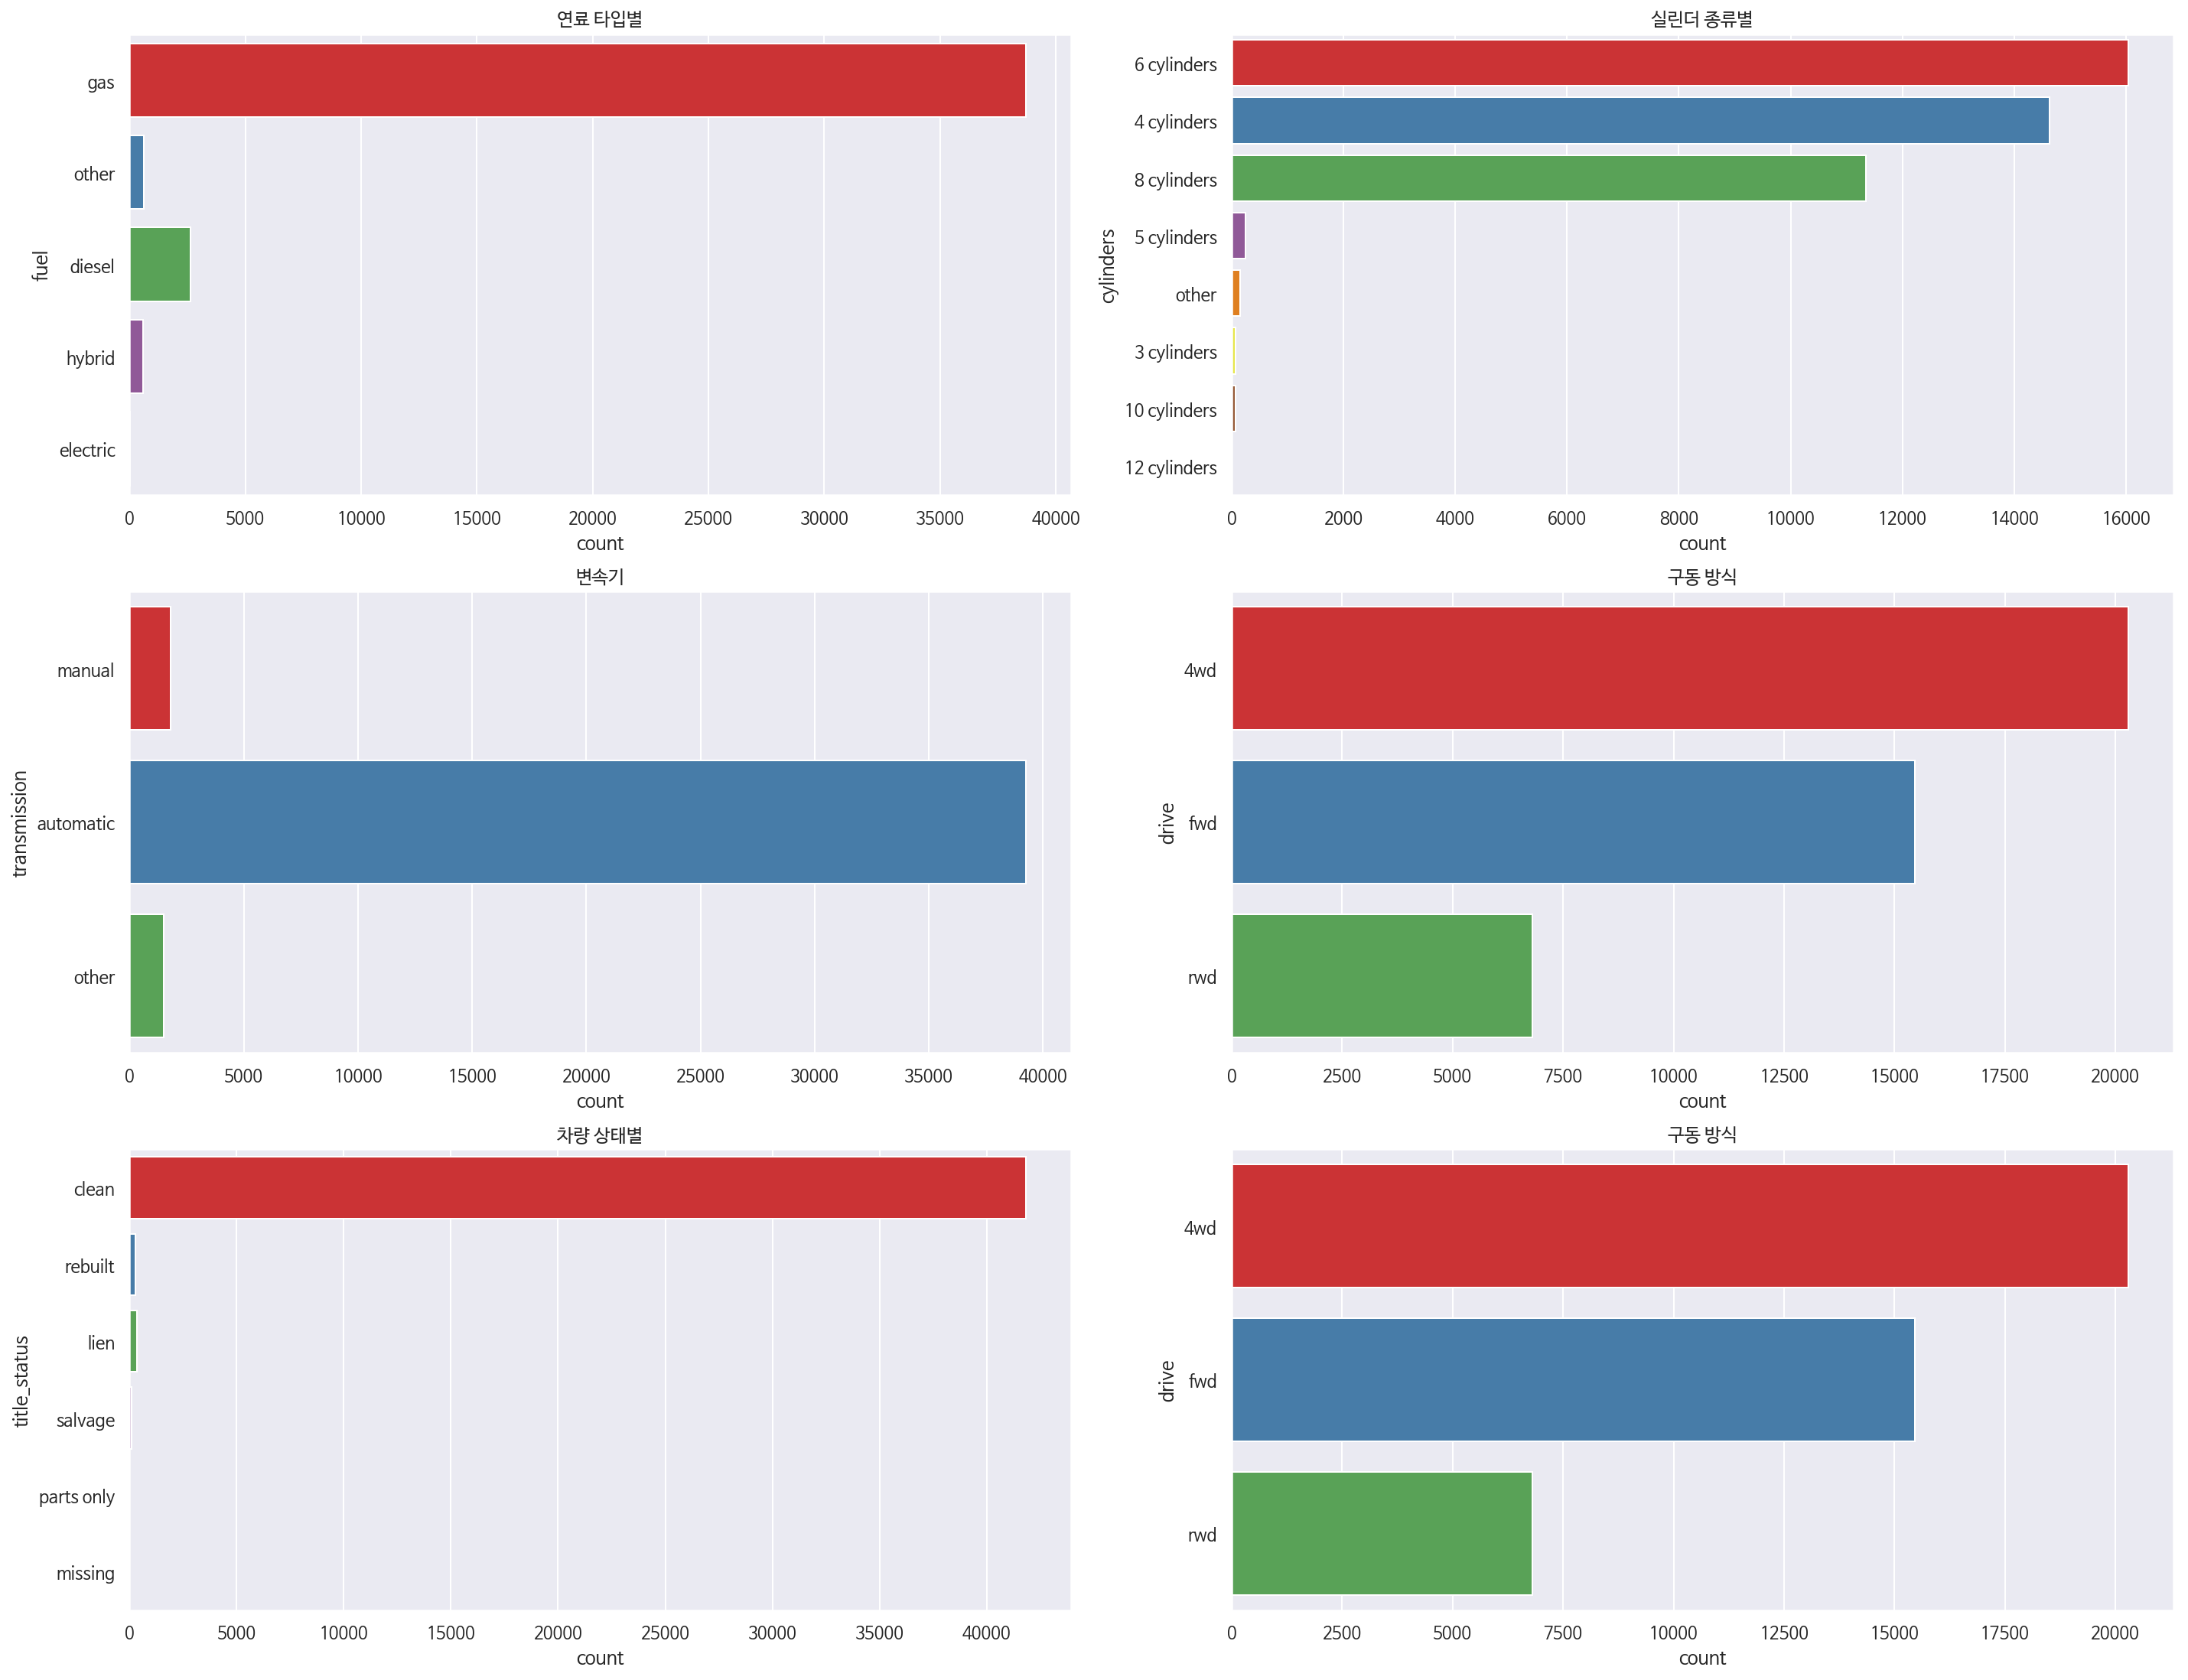

In [90]:
plt.figure(figsize=(20,30))
plt.subplot(621)
sns.countplot(
    data = test2,
    y = "fuel",
    palette='Set1',
)
plt.title("연료 타입별")


plt.subplot(622)
sns.countplot(
    data = test2,
    y = "cylinders",
    palette='Set1',
    order = test2['cylinders'].value_counts().index

)
plt.title("실린더 종류별")


plt.subplot(623)
sns.countplot(
    data = test2,
    y = "transmission",
    palette='Set1'
)
plt.title("변속기")

plt.subplot(624)
sns.countplot(
    data = test2,
    y = "drive",
    palette='Set1'
)
plt.title("구동 방식")


plt.subplot(625)
sns.countplot(
    data = test2,
    y = "title_status",
    palette='Set1'
)
plt.title("차량 상태별")

plt.subplot(626)
sns.countplot(
    data = test2,
    y = "drive",
    palette='Set1'
)
plt.title("구동 방식")

plt.tight_layout()
plt.show()


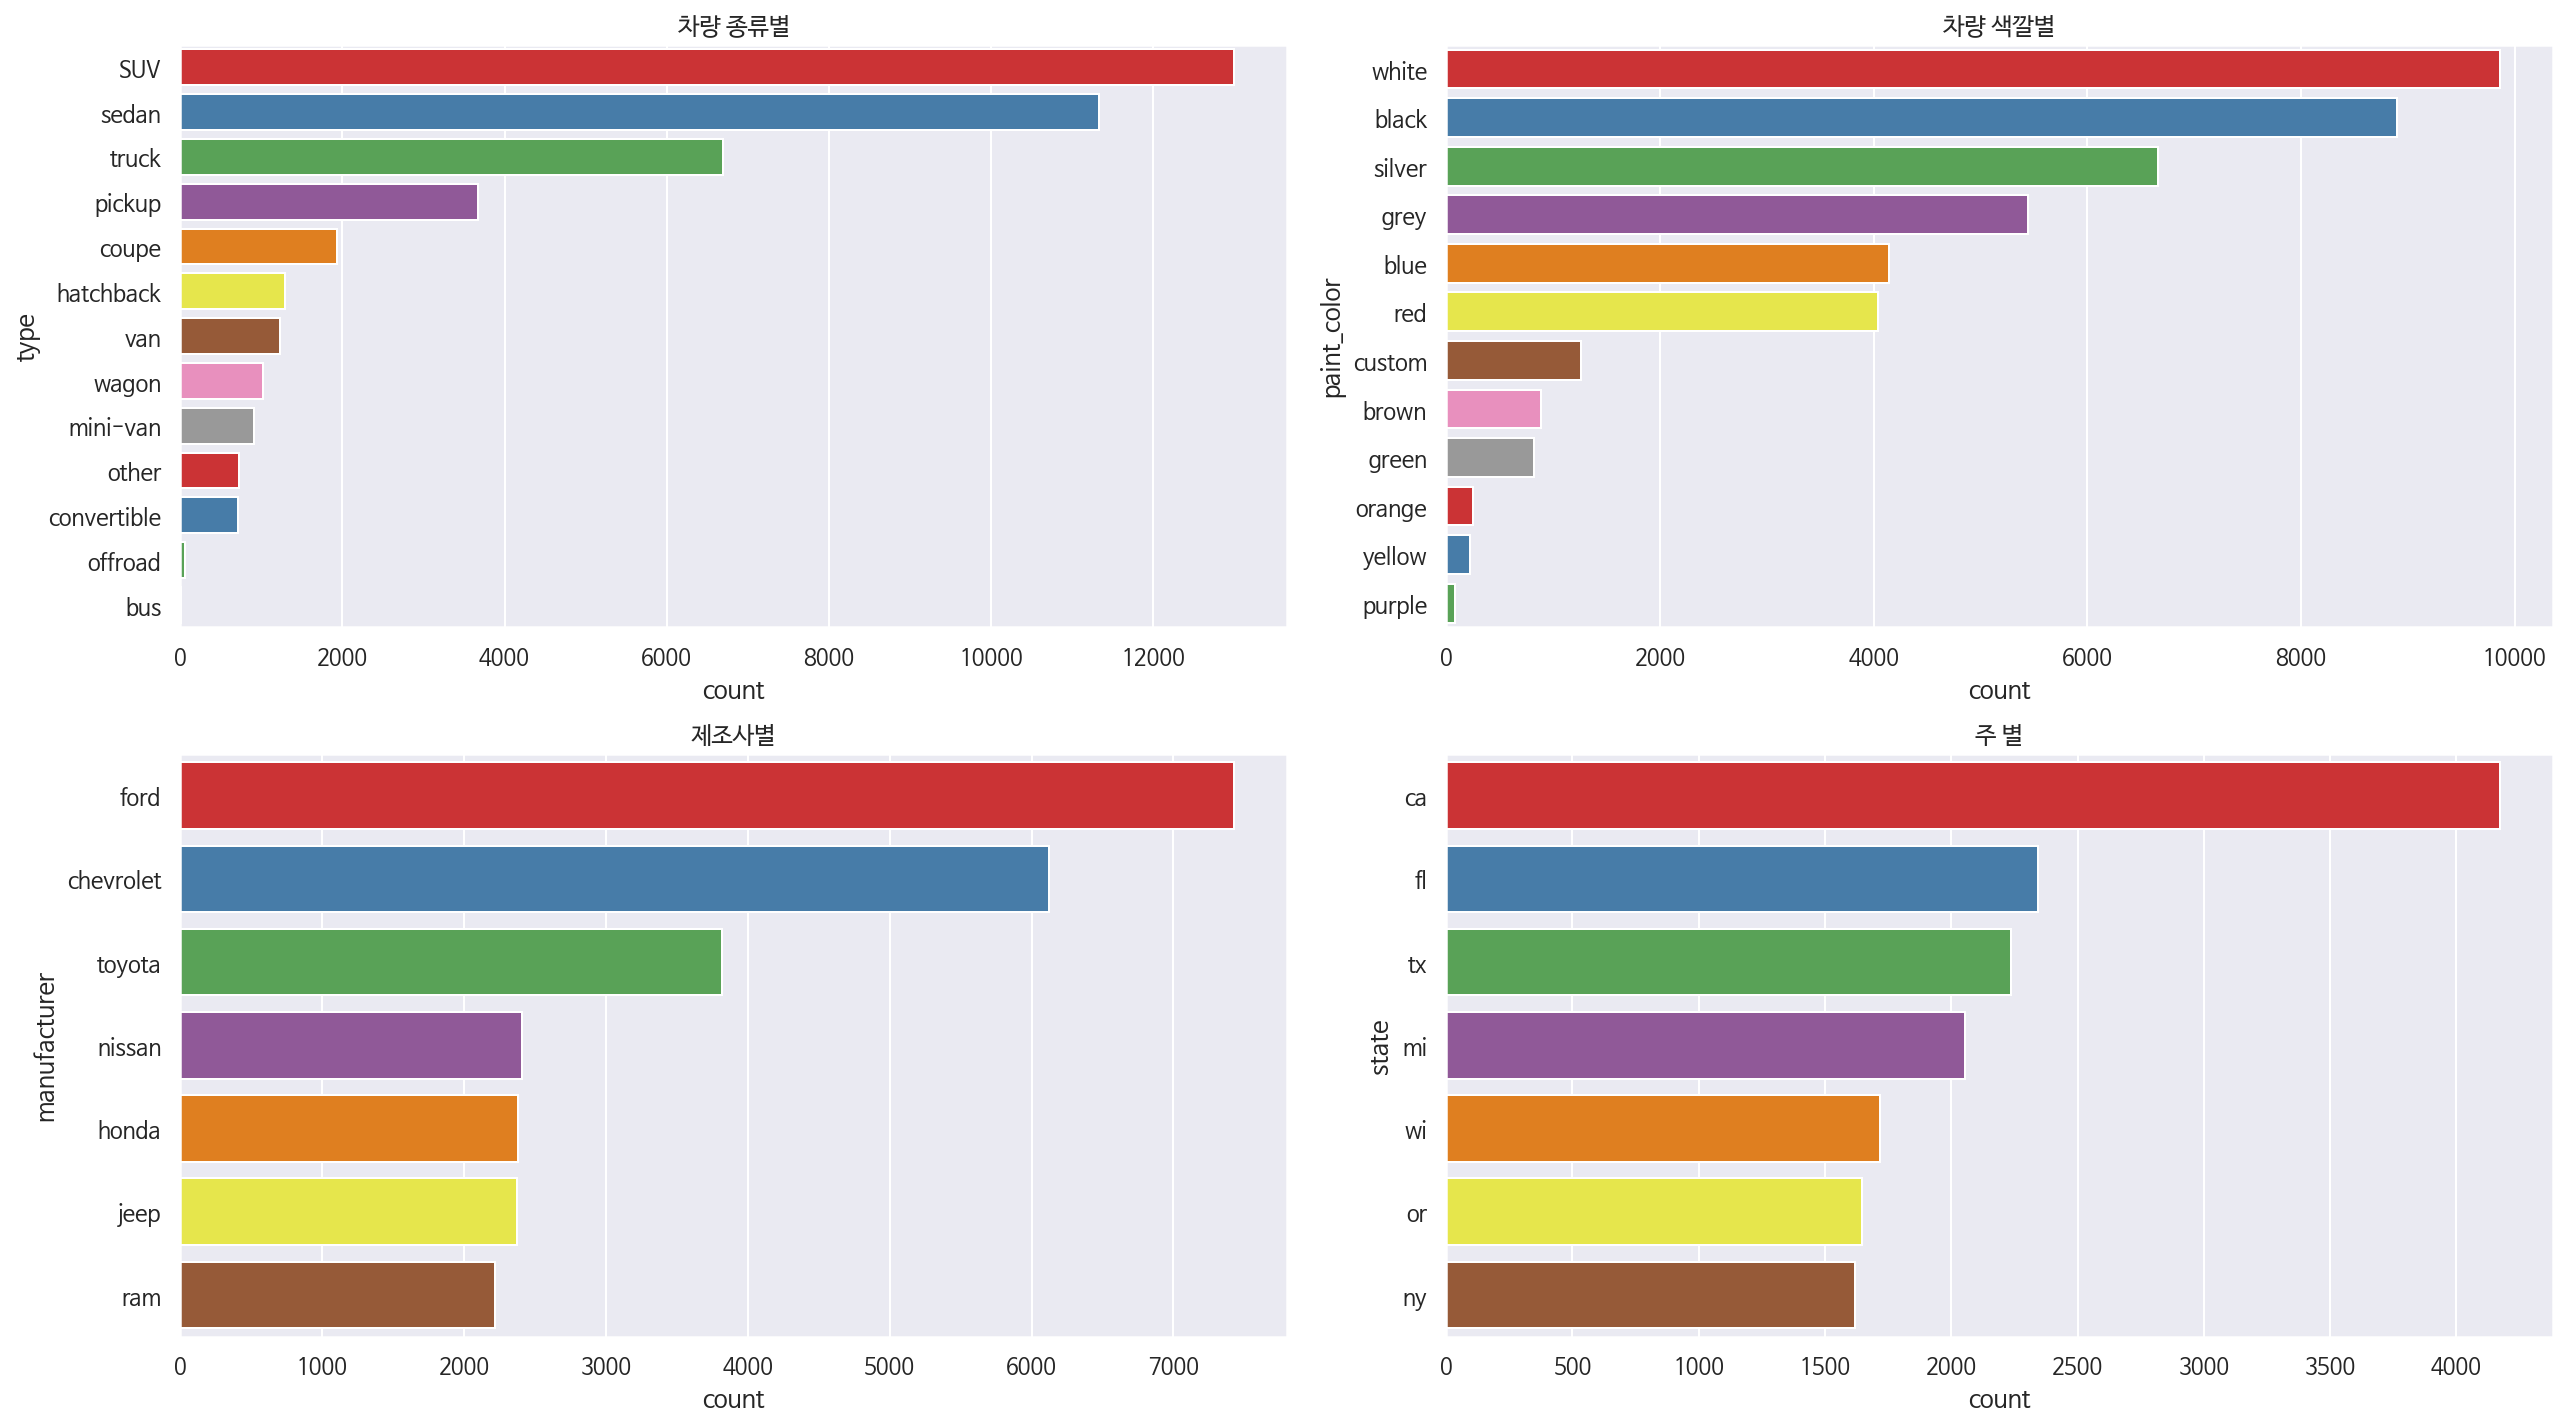

In [91]:
plt.figure(figsize=(18,10))

plt.subplot(221)
sns.countplot(
    data = test2,
    y = "type",
    palette='Set1',
    order = test2['type'].value_counts().index
)
plt.title("차량 종류별")


plt.subplot(222)
sns.countplot(
    data = test2,
    y = "paint_color",
    palette='Set1',
    order = test2['paint_color'].value_counts().index

)
plt.title("차량 색깔별")

plt.subplot(223)
sns.countplot(
    data = test2,
    y = "manufacturer",
    palette='Set1',
    order = test2['manufacturer'].value_counts().iloc[:7].index,

)
plt.title("제조사별")

plt.subplot(224)
sns.countplot(
    data = test2,
    y = "state",
    palette='Set1',
    order = test2['state'].value_counts().iloc[:7].index
)
plt.title("주 별")
plt.tight_layout()
plt.show()

##  부분회귀

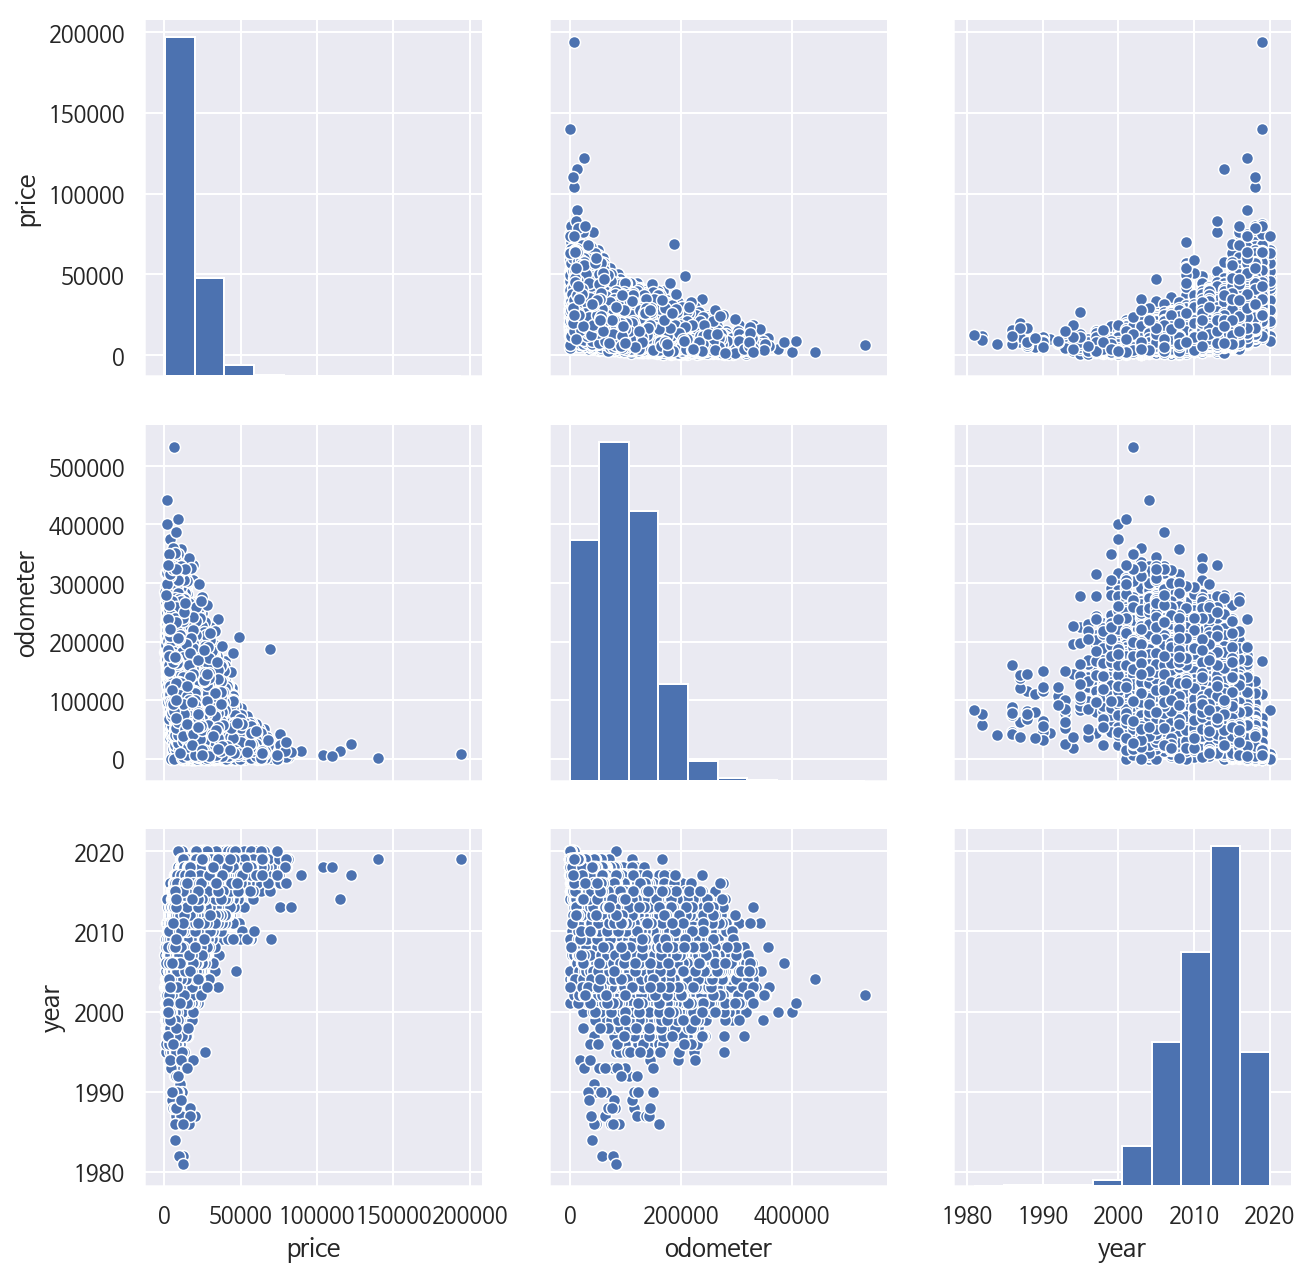

In [171]:
sns.pairplot(test2[['price','odometer','year']],size=3)

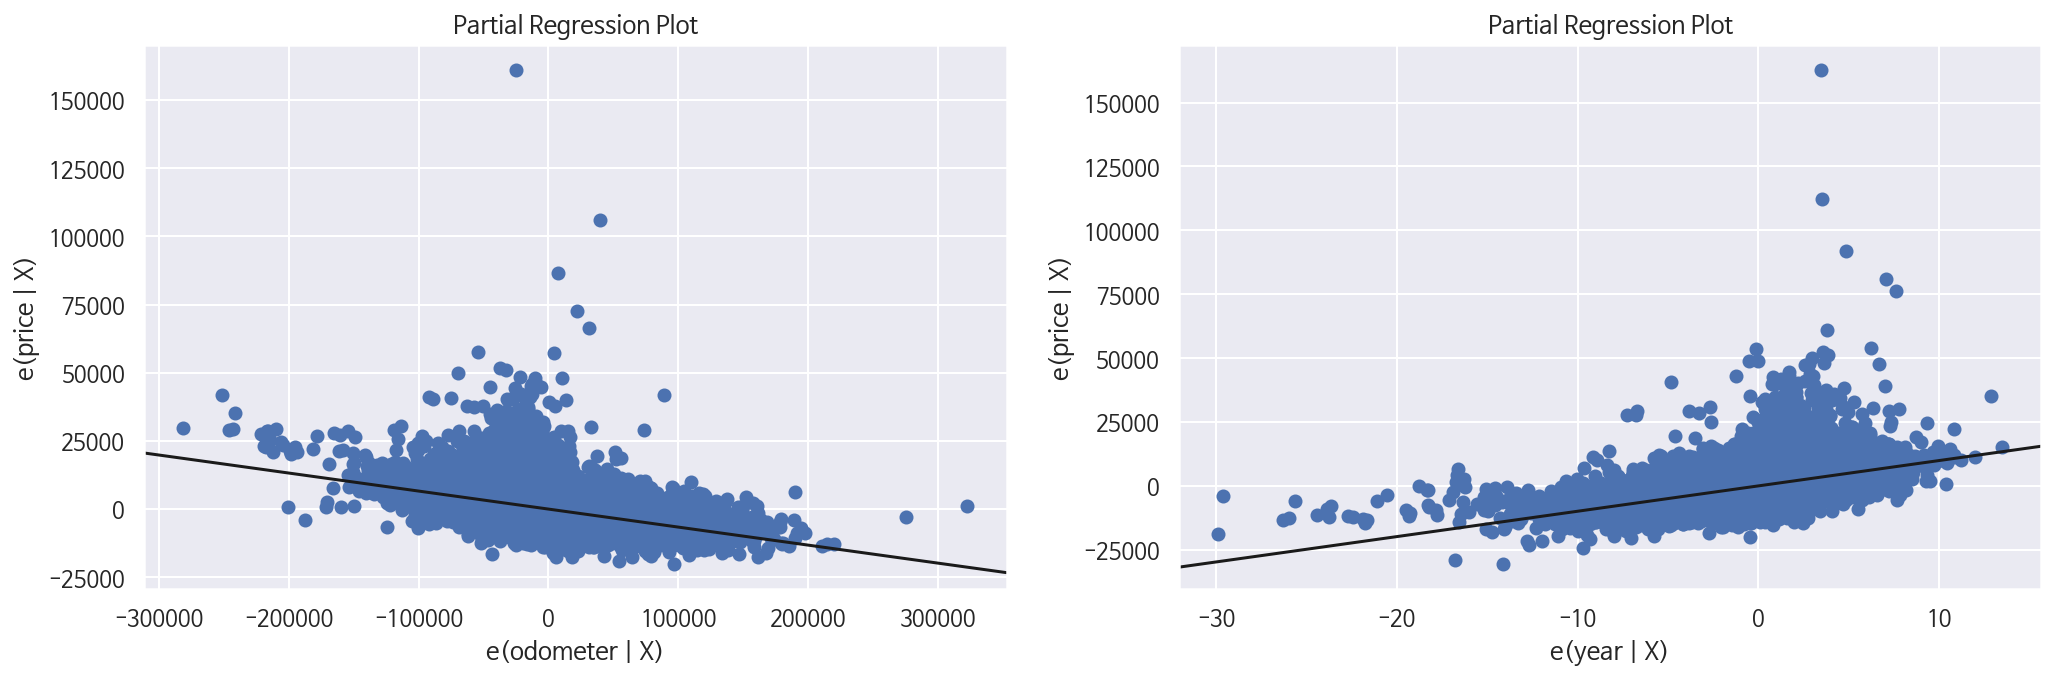

In [165]:
fig = plt.figure(figsize=(17,5))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

others = list(set(test2.columns).difference(set(["price", "odometer"])))
p, resids = sm.graphics.plot_partregress(
    "price", "odometer", others, data=test2, obs_labels=False, ret_coords=True, ax = ax1
)


others2 = list(set(test2.columns).difference(set(["price", "year"])))
p, resids = sm.graphics.plot_partregress(
    "price", "year", others2, data=test2, obs_labels=False, ret_coords=True, ax = ax2
)

plt.show()

train, test 파일로 나누기

In [ ]:
df = read_csv('train.csv')

# 모델

### column 정리
- 모델을 만드는데 필요한 컬럼만 따로 분류

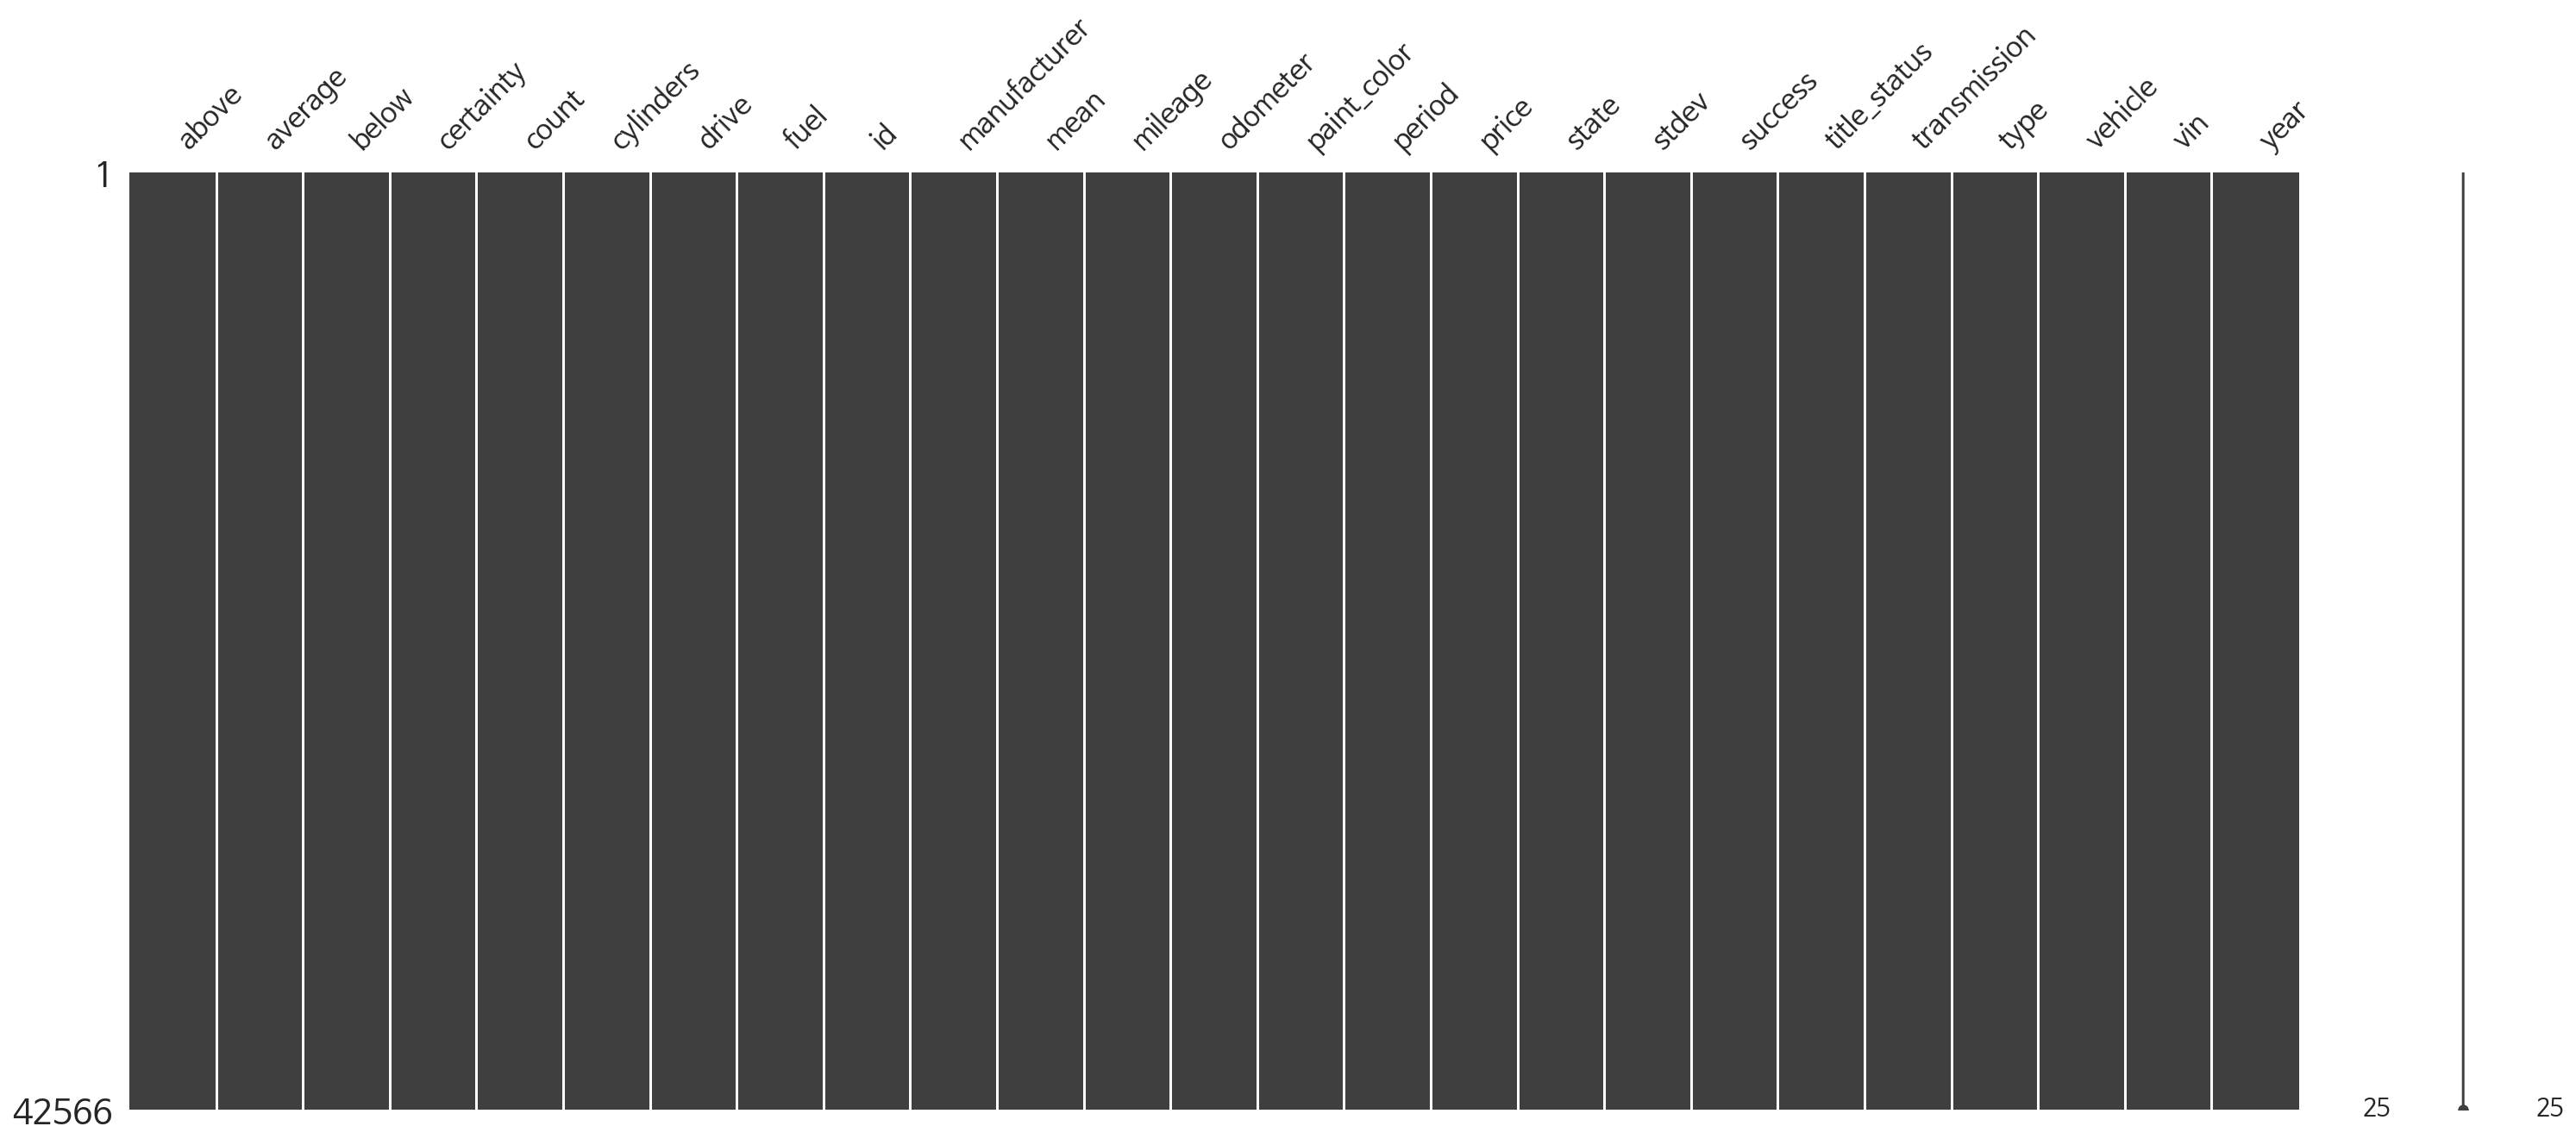

In [1088]:
msno.matrix(test2)

In [99]:
test2 = test2[['price','year','odometer','drive','fuel','manufacturer','state','title_status','transmission','type','paint_color','cylinders']]
test2.shape

(42566, 12)

### LinearRegression
- test size : 0.2
- price에 log를 취함

0.870326729418526
RMSE of Train Data :  0.22913854903323724
RMSE of Test Data :  0.2286226442343226
[0.87055815 0.83945234 0.86712709 0.86386649 0.85495622]


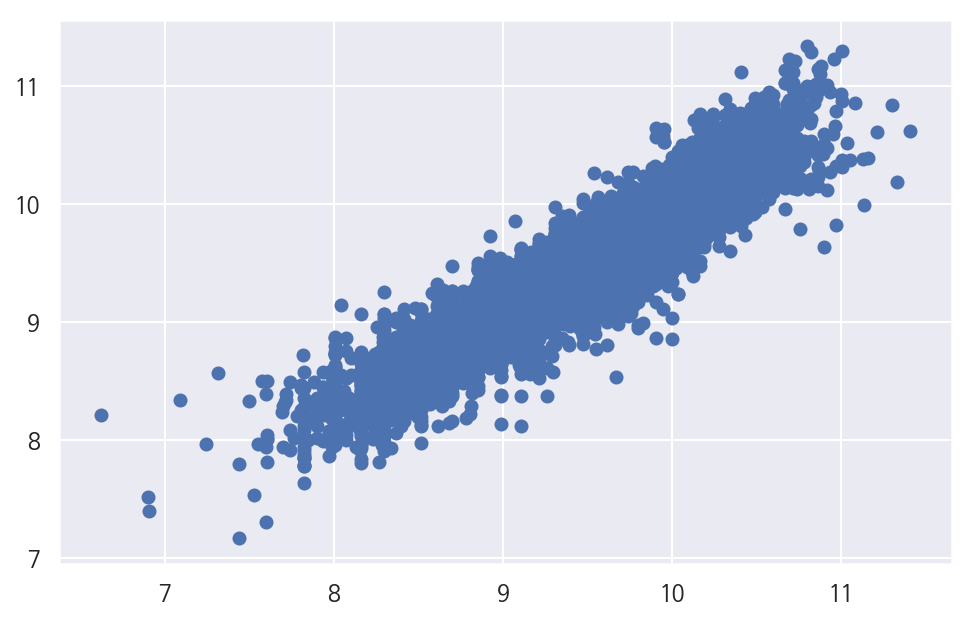

In [200]:
X = test2[test2.columns.difference(['id_x','model','vin','price'])]
Y = np.log(test2['price'])
X = pd.get_dummies(data=X, drop_first=True)


X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = .20, random_state = 40)

test_df = pd.concat([Y_train,X_train],axis=1)

model = linear_model.LinearRegression() 
result = model.fit(X_train, Y_train)
predicted = result.predict(X_test)
print(r2_score(Y_test,predicted))
plt.scatter(Y_test,predicted)


pred_tr = result.predict(X_train)
pred_test = result.predict(X_test)
rmse_tr = (np.sqrt(mean_squared_error(Y_train, pred_tr)))
rmse_test = (np.sqrt(mean_squared_error(Y_test, pred_test)))


# cv = KFold(10, shuffle=True, random_state=0)
a = cross_val_score(model, X, Y, scoring=None, cv=5)

print('RMSE of Train Data : ', rmse_tr)
print('RMSE of Test Data : ', rmse_test)
print(a)

### sm.OLS.from_formula

In [105]:
# test2 = test2[['price','year','mileage','drive','fuel','manufacturer','state','title_status','transmission','type','paint_color','cylinders']]

X = test2[test2.columns.difference(['price'])]
Y = np.log(test2['price'])


X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = .20,random_state=0)

test_df = pd.concat([Y_train,X_train],axis=1)


model = sm.OLS.from_formula("price ~ scale(odometer) + scale(year) +{}".format("+".join(test_df.columns.difference(['price','odometer','year'])))+"+0",test_df)
result = model.fit()
prediction = result.predict(X_test)
print(r2_score(Y_test,prediction))
print(result.summary())

0.8652658116593878
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.869
Model:                            OLS   Adj. R-squared:                  0.868
Method:                 Least Squares   F-statistic:                     1690.
Date:                Wed, 01 Apr 2020   Prob (F-statistic):               0.00
Time:                        20:30:02   Log-Likelihood:                 1900.1
No. Observations:               34052   AIC:                            -3532.
Df Residuals:                   33918   BIC:                            -2402.
Df Model:                         133                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------

# 데이터 한번에 불러오는 함수

In [122]:
def get_data_by_sigma(num):
    global test2
    test2 = test[(test['price'] >= (test['average'] - (test['stdev']*num))) & (test['price'] <= (test['average'] + (test['stdev']*num)))]
    test2 = test2[test2['mileage'] == test2['odometer']]
    test2['year'] = test2['year'].apply(lambda x : 2019 if x < 1980 else x)
    test2= test2[test2['odometer'] != 0]
    test2= test2[test2['price'] != 0]
    test2 = test2[['price','year','odometer','drive','fuel','manufacturer','state','title_status','transmission','type','paint_color','cylinders']]
    print("{} sigma data : ".format(num),test2.shape)

In [123]:
get_data_by_sigma(1)

1 sigma data :  (42566, 12)


# 교차 검증

In [106]:
from sklearn.base import BaseEstimator, RegressorMixin
import statsmodels.formula.api as smf
import statsmodels.api as sm

class StatsmodelsOLS(BaseEstimator, RegressorMixin):
    def __init__(self, formula):
        self.formula = formula
        self.model = None
        self.data = None
        self.result = None
        
    def fit(self, dfX, dfy):
        self.data = pd.concat([dfX, dfy], axis=1)
        self.model = smf.ols(self.formula, data=self.data)
        self.result = self.model.fit()
        
    def predict(self, new_data):
        return self.result.predict(new_data)

In [111]:
from sklearn.model_selection import KFold

# 부트스트래핑 후 
booted_data = test2.sample(frac=5, replace=True)
model = StatsmodelsOLS("price ~ scale(odometer) + scale(year) +{}".format("+".join(test2.columns.difference(['price','odometer','year'])))+"+0")

dfX = booted_data[booted_data.columns.difference(['price'])]
dfy = np.log(booted_data['price'])
cv = KFold(5, shuffle=True, random_state=0)
cross_val_score(model, dfX, dfy, scoring="r2", cv=cv)

array([0.8678312 , 0.86841044, 0.86800374, 0.86781721, 0.86908847])

# VIF Factor

In [1285]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(
    dfX.values, i) for i in range(dfX.shape[1])]
vif["features"] = dfX.columns
vif = vif.sort_values("VIF Factor").reset_index(drop=True)
vif

,VIF Factor,features
0,1.00,title_status_parts only
1,1.00,title_status_missing
2,1.01,manufacturer_ferrari
3,1.01,manufacturer_land rover
4,1.01,type_bus
...,...,...
128,20.72,manufacturer_ford
129,170.87,cylinders_8 cylinders
130,222.92,cylinders_4 cylinders
131,241.85,cylinders_6 cylinders


In [1286]:
vif.sort_values(by=['VIF Factor'], ascending=False).iloc[:20]

,VIF Factor,features
132,852.60,year
131,241.85,cylinders_6 cylinders
130,222.92,cylinders_4 cylinders
129,170.87,cylinders_8 cylinders
128,20.72,manufacturer_ford
127,19.97,fuel_gas
126,17.27,manufacturer_chevrolet
125,11.01,manufacturer_toyota
124,7.50,state_ca
123,7.31,manufacturer_jeep


In [1287]:
test2['cylinders'].value_counts()

6 cylinders     16040
4 cylinders     14637
8 cylinders     11349
5 cylinders       252
other             148
3 cylinders        70
10 cylinders       68
12 cylinders        2
Name: cylinders, dtype: int64

In [ ]:
# 더미 변수화 하면서 오류 발생 시키는 카테고리 값들 수정하기
for column in test2.columns.difference(['price','mileage','year']):
    test2[column] = test2[column].apply(lambda x : x.replace("-","").replace(" ","") if "-" or " " in x else x)
test2['cylinders'] = test2['cylinders'].str.get(0)